# Meta analysis of Li-S host matrices

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import os
import glob
import pandas as pd
import ipywidgets as wg
import re
import seaborn as sns

from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines
import matplotlib.patches as mpatch 

import warnings
warnings.filterwarnings(action="ignore", message="findfont") ## ignores error in Pie chart function

## User-defined functions
from Bibliography import Bibliography
from GraphScan import GraphScan
from make_bibliography_df import make_bibliography_df
from PieOuterLabels import PieOuterLabels, func

# Plot setups and custom functions

In [2]:
if os.path.isdir(r"C:\Users\engs2608\OneDrive - Nexus365\Documents\Meta analysis draft - OX\Figures"):
    save_path = r"C:\Users\engs2608\OneDrive - Nexus365\Documents\Meta analysis draft - OX\Figures"
elif os.path.isdir(r"C:\Users\Liam\OneDrive - Nexus365\Documents\Meta analysis draft - OX\Figures"):
    save_path = r"C:\Users\Liam\OneDrive - Nexus365\Documents\Meta analysis draft - OX\Figures"

In [3]:
## Functions for filtering data frames
def cont_keyword(df, keyword, column="Carbon type", case=True):
    return df[df[column].astype(str).str.contains(keyword, case)]

def cont_multi_keywords(df, list_of_keywords, column="Carbon type", case=True):
    return df[df[column].astype(str).str.contains("|".join(list_of_keywords), case)]

def excludes_keywords(df, list_of_keywords, column="Carbon type", case=False):
    return df[~df[column].astype(str).str.contains("|".join(list_of_keywords), case)]

In [4]:
## size of A4 paper in inches (for plot legibility)
a4_inches = (11.7, 8.3)
font_size = 8

half_width_figsize=(0.35*a4_inches[1], 0.35*a4_inches[1]/1.2)
full_width_figsize=(0.8*a4_inches[1], 0.54*0.8*a4_inches[1])

In [5]:
if os.path.isdir(os.path.join(save_path, "Font_size_{}".format(font_size), "png")) == False:
    os.makedirs(os.path.join(save_path, "Font_size_{}".format(font_size), "png"))
    os.makedirs(os.path.join(save_path, "Font_size_{}".format(font_size), "eps"))
save_path = os.path.join(save_path, "Font_size_{}".format(font_size))

In [6]:
## Plot set ups
from UCL_colors import UCL_colors
c = UCL_colors()

plt.rcParams.update({"xtick.direction": "in"})
plt.rcParams.update({"ytick.direction": "in"})
plt.rcParams.update({"xtick.top": True})
plt.rcParams.update({"ytick.right": True})

plt.rcParams.update({"font.size": font_size})

pie_width = 0.3
pie_radius = 1

In [7]:
short_name_labels = {"Graphene": "Graphene",
                     "Graphene oxide": "GO",
                     "Templated carbon": "TMC", 
                     "Carbon nanotubes": "CNTs",
                      "Mixed carbon": "Mixed"}

In [8]:
# carbon_types_colors = {"Graphene": [*c.saturation(60, ["Light Red"]).values()][0],
#                        "Graphene oxide+\nGraphene": [*c.saturation(40, ["Mid Purple"]).values()][0],
#                        "Graphene oxide": [*c.saturation(60, ["Mid Blue"]).values()][0],
#                              'Reduced graphene oxide+\nGraphene oxide': [*c.saturation(60, ["Mid Green"]).values()][0],
#                        "Reduced graphene oxide": [*c.saturation(60, ["Yellow"]).values()][0],
#                        "Reduced graphene oxide+\nGraphene": [*c.saturation(60, ["Orange"]).values()][0],
#                             "Templated carbon": [*c.saturation(100, ["Grey"]).values()][0],
#                        "Templated carbon+\nOther": [*c.saturation(60, ["Stone"]).values()][0],
#                        "Carbon nanotubes": [*c.saturation(60, ["Light Blue"]).values()][0],
#                        "Carbon nanotubes+\nOther": [*c.saturation(60, ["Light Green"]).values()][0],
#                        "Mixed carbon": [*c.saturation(10, ["Grey"]).values()][0]} ## NEEDS MODIFICATION FOR CLARITY

colorblind = sns.color_palette(palette='colorblind')

carbon_types_labels = ["Graphene", "Graphene oxide", "Templated carbon", "Carbon nanotubes", "Mixed carbon", "Reduced graphene oxide"]
carbon_types_colors = dict([(key, colorblind[nkey]) for nkey, key in enumerate(carbon_types_labels)])
carbon_types_colors["Mixed carbon"] = colorblind[7]

In [9]:
colorblind_desat = sns.color_palette(palette='colorblind', desat=0.5)

In [10]:
colors_infiltration_labels = ["Thermal", "Thermal+\nSolution", "Solution", "Chemical", "Thermal+\nChemical", "Other/ mixed"]
colors_infiltration = dict([(key, colorblind_desat[nkey]) for nkey, key in enumerate(colors_infiltration_labels)])
colors_infiltration["Solution"] = colorblind_desat[4]
colors_infiltration["Thermal+\nChemical"] = colorblind_desat[2]
colors_infiltration["Other/ mixed"] = colorblind_desat[7]

# Data import notes: 
* wang 2019 cotton hierarchical quotes separate BJH and BET surface area, with BET > BJH
- Note Wang 2020 Graphene nanosheets - two different composites tested with different rate change regimes!
- Wang 2017 freestanding sandwich reports formation period 12 hours before cycling!

#### Further comparators?
* Different numbers of hosts tested per paper
* Control electrodes (without host/ with only CB)

# Widgets for data import
## Article details in `Bibliography()`

In [11]:
bib = Bibliography()
bib.tab

## Graph scanning (interpolation) in `GraphScan()`

In [12]:
gs = GraphScan()
gs.tab

## Collate article details and numerical info in `make_bibliography_df`

In [13]:
df = make_bibliography_df()

df.insert(len(df.columns), 'concat_label', 
          [" ".join((name for name in list(df.loc[idx][["First author", "Year", "Optional label"]])))
                               for idx in range(len(df))])
df = df.set_index(np.arange(len(df)))

bibliography_list = np.unique([" ".join((name for name in list(df.loc[idx][["First author", "Year", "Optional label"]])))
                               for idx in range(len(df))])

In [14]:
## Fixing data entries that may include "+" in string to ensure mixtures are correctly identified by text search:
df["Carbon type adj"] = df["Carbon type"].str.replace("+", "mix", regex=True)

df["Carbon type adj"] = df["Carbon type"].str.replace("RGO", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("rGO", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("reduced graphene oxide", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("Reduced graphene oxide", "_R_G_O", regex=True)

In [15]:
df.to_csv(os.path.join(os.path.split(os.path.split(save_path)[0])[0], "fig2fig_collated_dataframe.csv"))

In [16]:
available_data = df.iloc[[idx for idx, values in enumerate(df["Scanned data"]) if len(values)>0]]
available_data = available_data.set_index(np.arange(len(available_data)))

# Types of carbon host matrix

Define different carbon host types, and the key words to search for and/ or exclude from the user-defined labels in the `available_data` dataframe

In [17]:
carbon_types = {"Graphene": {"include": ["graphene"],
                             "exclude": ["composite", "reduced", "oxide", "mix", "_R_G_O", "GO", "wrapped"]},
                "Graphene oxide": {"include": ["graphene oxide", "GO"],
                                   "exclude": ["Reduced", "reduced", "and", "mix", "_R_G_O", "wrapped"]},
                "Reduced graphene oxide": {"include": ["_R_G_O"],
                                           "exclude": ["and", "mix", "wrapped", "graphene oxide", "GO"]},
                "Templated carbon": {"include": ["hierarchical", "template", "CMK", "mesoporous"],
                                     "exclude": ["graphene", "mix", "wrapped"]},
                "Carbon nanotubes": {"include": ["nanotube", "CNT", "MWNT"],
                                     "exclude": ["and", "graphene oxide", "mix", "wrapped"]}
                }

Identify the rows of `available_data` that include the keywords used to define each category, excluding keywords indicative of overalapping with other categories:

In [18]:
carbon_data = dict([(keys, 
                     cont_multi_keywords(df=excludes_keywords(df=available_data,
                                                              list_of_keywords=values["exclude"],
                                                              column="Carbon type adj",
                                                              case=True),
                                        list_of_keywords=values["include"],
                                        column="Carbon type",
                                        case=False)) for keys, values in carbon_types.items()])

Identify the rows of `available_data` that include the keywords used to define each category, **including** keywords which may result in overlaps between different categories:

In [19]:
carbon_data_inclusive = dict([(keys, 
                               cont_multi_keywords(df=available_data,
                                                   list_of_keywords=values["include"],
                                                   column="Carbon type adj",
                                                   case=False)) for keys, values in carbon_types.items()])

Find the rows of `carbon_data_inclusive` that do not appear in `carbon_data`: the rows identified in this step correspond to mixtures of carbon types, while filtering out rows that correspond to a single carbon type:

In [20]:
carbon_data_overlaps = {}

for nk1, keys_1 in enumerate(carbon_data_inclusive.keys()):
    for nk2, keys_2 in enumerate(carbon_data_inclusive.keys()):
        if nk2 < nk1:
            overlap_AB = set(carbon_data_inclusive[keys_1].index) & set(carbon_data_inclusive[keys_2].index)            
            carbon_data_overlaps.update([("+".join((keys_1, keys_2)), carbon_data_inclusive[keys_1].loc[list(overlap_AB)])])

`carbon_data` contains data for **single** carbon types only.

`carbon_data_overlaps` contains data for **mixed** carbon types only

These two dictionaries are combined so that the single and mixed hosts are in the same dictionary, but without duplicates:

In [21]:
carbon_types_combined = {**carbon_data, **carbon_data_overlaps}

# Carbon types chord chart

In [22]:
cross_over = np.full((len(carbon_data), len(carbon_data)), 0, dtype=int)

## Carbon data contains only exclusive/ single types of carbon (A, B...)
for ni, ii in enumerate(carbon_data.keys()): 
    for nj, jj in enumerate(carbon_data.keys()):
        ## For single carbon types (A, B...):
        if ni == nj:
            cross_over[ni, nj] = len(carbon_types_combined[ii])
        ## Multiple types of carbon (A+B)
        if nj > ni:
            cross_over[ni, nj] = len([carbon_types_combined[keys] for keys in carbon_types_combined.keys()
                                      if ii in keys and "+" in keys and jj in keys][0])
            ## Symmetric (i.e. A+B = B+A)
            cross_over[nj, ni] = cross_over[ni, nj]
        

In [23]:
## Chord chart code
import matplotlib.patches as patches
from matplotlib.path import Path

class EndPoints(object):
    """
    Gives start and end points, and width, of arc joining two categories
    Start and end points can be adjusted/ offset within 'make_arc'
    """
    def __init__(self, data, wedges, start_category, end_category, i_radius=0.7):
        """
        Inputs
        ---------
        data: np.array
            symmetrical array with single categories on major diagonal
        wedges: matplotlib patch
            obtained via wedges, texts = ax.pie(...)
        start_category: int
            index of wedge to use as starting point
        end_category: int
            index of wedge to use as end point
        i_radius:
            inner radius of pie chart
        """
        total = np.sum(np.sum(data, axis=1))
        i = start_category
        j = end_category
        
        self.start_x1 = i_radius*np.cos(np.deg2rad(wedges[i].theta1+(np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360))
        self.start_x2 = i_radius*np.cos(np.deg2rad(wedges[i].theta1+(np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360))
        self.start_y1 = i_radius*np.cos(np.deg2rad(wedges[j].theta1+(np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360))
        self.start_y2 = i_radius*np.cos(np.deg2rad(wedges[j].theta1+(np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360))
        
        self.end_x1 = i_radius*np.sin(np.deg2rad(wedges[i].theta1+(np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360))
        self.end_x2 = i_radius*np.sin(np.deg2rad(wedges[i].theta1+(np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360))
        self.end_y1 = i_radius*np.sin(np.deg2rad(wedges[j].theta1+(np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360))
        self.end_y2 =  i_radius*np.sin(np.deg2rad(wedges[j].theta1+(np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360))
        
def make_arc(ax, i, j, wedges, data, r=0.9, start_angle_offset=0, end_angle_offset="match",
             offset=0.6, offset_stretch=1.25, angle_offset_degrees=True, facecolor=None, edgecolor="none",
             facealpha=1):
    if end_angle_offset == "match":
        end_angle_offset = start_angle_offset
    if angle_offset_degrees == False:
        start_angle_offset = np.rad2deg(start_angle_offset)
        end_angle_offset = np.rad2deg(end_angle_offset)
    
    i_x1 = r*np.cos(np.deg2rad(start_angle_offset+wedges[i].theta1+((np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360)))
    i_y1 = r*np.sin(np.deg2rad(start_angle_offset+wedges[i].theta1+((np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360)))

    j_x1 = r*np.cos(np.deg2rad(end_angle_offset+wedges[j].theta1+((np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360)))
    j_y1 = r*np.sin(np.deg2rad(end_angle_offset+wedges[j].theta1+((np.sum([data[i, jj] for jj in range(j)])-data[i, i])/total*360)))

    i_x2 = r*np.cos(np.deg2rad(start_angle_offset+wedges[i].theta1+((np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360)))
    i_y2 = r*np.sin(np.deg2rad(start_angle_offset+wedges[i].theta1+((np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360)))

    j_x2 = r*np.cos(np.deg2rad(end_angle_offset+wedges[j].theta1+((np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360)))
    j_y2 = r*np.sin(np.deg2rad(end_angle_offset+wedges[j].theta1+((np.sum([data[i, jj] for jj in range(j+1)])-data[i, i])/total*360)))

    inner_midpoint = ((i_x2+j_x1)/2, (i_y2+j_y1)/2)
    n_slope = -1/((j_y1-i_y2)/(j_x1-i_x2))
    n_intercept = inner_midpoint[1]-n_slope*inner_midpoint[0]

    outer_midpoint = ((i_x1+j_x2)/2, (i_y1+j_y2)/2)
    verts = [(i_x1, i_y1), ## MOVETO
             (i_x2, i_y2), ## LINETO
             (inner_midpoint[0]-offset*np.cos(np.arctan(n_slope)), inner_midpoint[1]-offset*np.sin(np.arctan(n_slope))), ## CURVE3
             (j_x1, j_y1), (j_x2, j_y2), ## LINETO
             (outer_midpoint[0]-offset_stretch*offset*np.cos(np.arctan(n_slope)), outer_midpoint[1]-offset_stretch*offset*np.sin(np.arctan(n_slope))), ## CURVE3
             (i_x1, i_y1)]
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.CURVE3,
             Path.LINETO, Path.LINETO, Path.CURVE3,
            Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, color=facecolor, edgecolor=edgecolor, alpha=facealpha)
    
    ax.add_patch(patch)
    
def make_label(ax, wedges, wedge_idx, text, radius=0.95, color="white"):
    angle = (wedges[wedge_idx].theta1+wedges[wedge_idx].theta2)/2
    x_pos = radius*np.cos(np.deg2rad(angle))
    y_pos = radius*np.sin(np.deg2rad(angle))
    ax.annotate(text, xy=(x_pos, y_pos), color=color, ha="center", va="center")

<IPython.core.display.Javascript object>


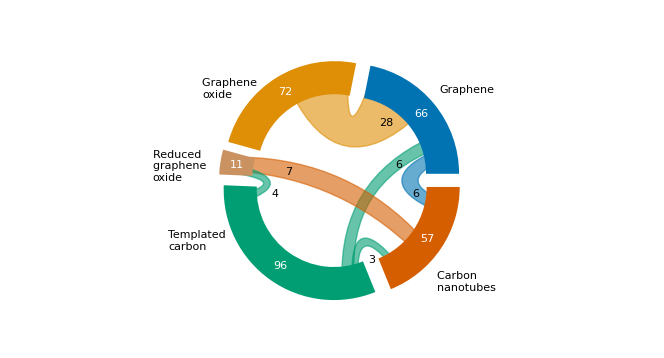

C:\Users\Liam\AppData\Local\Temp\ipykernel_17036\2440011427.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = patches.PathPatch(path, color=facecolor, edgecolor=edgecolor, alpha=facealpha)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
fig, ax = plt.subplots(figsize=full_width_figsize)
radius = 1
width = 0.3
i_radius = radius-0.2*width
r = radius-0.7*width
total = np.sum(np.sum(cross_over, axis=1))
wedges, texts = ax.pie(np.sum(cross_over, axis=1), radius=1, 
                       wedgeprops={"width": 0.3}, explode=np.full((cross_over.shape[1]), 0.1))
ax.cla()

arc_alpha = 0.6

make_arc(ax, 0, 1, wedges, cross_over, start_angle_offset=40, end_angle_offset=7,
         facealpha=arc_alpha, facecolor=carbon_types_colors["Graphene oxide"]) ## Graphite to GO
make_arc(ax, 0, 3, wedges, cross_over, facealpha=arc_alpha, offset=0.5, start_angle_offset=-15, end_angle_offset=60, 
          facecolor=carbon_types_colors["Templated carbon"], offset_stretch=1) ## Graphite to CNTs
make_arc(ax, 0, 4, wedges, cross_over, offset=0.6, start_angle_offset=-30, end_angle_offset=10, offset_stretch=0.6,
         facealpha=arc_alpha, facecolor=carbon_types_colors["Graphene"]) ## Graphite to CNTs
make_arc(ax, 2, 4, wedges, cross_over, offset=-0.3, facealpha=arc_alpha, 
            end_angle_offset=20, start_angle_offset=-3, facecolor=carbon_types_colors["Carbon nanotubes"]) ## RGO to CNTs
make_arc(ax, 2, 3, wedges, cross_over, offset=-0.4, facealpha=arc_alpha,
         start_angle_offset=7, end_angle_offset=10, 
         facecolor=carbon_types_colors["Templated carbon"]) ## RGO to MC
make_arc(ax, 3, 4, wedges, cross_over, offset=0.5, facealpha=arc_alpha,
         start_angle_offset=80, end_angle_offset=-10, 
         facecolor=carbon_types_colors["Templated carbon"]) ## CNTs to MCs

wedges, texts = ax.pie(np.sum(cross_over, axis=1), wedgeprops={"width": 0.3}, radius=1,
                       colors=[carbon_types_colors[keys] for keys in carbon_data.keys()], 
                       explode=np.full((cross_over.shape[1]), 0.1))

ax.annotate(text="Graphene", xy=(0.9, 0.8))
ax.annotate(text="Carbon \nnanotubes", xy=(0.85, 0.1), ha="left", xycoords=ax.transAxes)
ax.annotate(text="Templated \ncarbon", xy=(-0.125, 0.25), ha="left", xycoords=ax.transAxes)
ax.annotate(text="Reduced \ngraphene \noxide", xy=(-0.18, 0.5), xycoords=ax.transAxes)
ax.annotate(text="Graphene \noxide", xy=(0, 0.8), xycoords=ax.transAxes)

ax.annotate(text=str(cross_over[0, 1]), xy=(0.35, 0.5))
ax.annotate(text=str(cross_over[0, 3]), xy=(0.5, 0.12))
ax.annotate(text=str(cross_over[0, 4]), xy=(0.65, -0.15))
ax.annotate(text=str(cross_over[2, 3]), xy=(-0.62,-0.15))
ax.annotate(text=str(cross_over[2, 4]), xy=(-0.5, 0.05))
ax.annotate(text=str(cross_over[3, 4]), xy=(0.25, -0.75))

for nvalue, value in enumerate(np.sum(cross_over, axis=1)):
    make_label(ax, wedges, nvalue, value)
    
plt.savefig(os.path.join(save_path, "png", "4_Chort_chart_host_materials.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "4_Chord_chart_host_materials.eps"), bbox_inches="tight")

# Sulfur loading methods

Define different sulfur loading methods, and the key words to search for and/ or exclude from the user-defined labels in the `available_data` dataframe

In [25]:
sulfur_loading_labels = {"Thermal": {"include": ["thermal", "melt", "155"],
                                     "exclude": ["solution", "chemical", "toluene", "CS2"]},
                         "Chemical": {"include": ["Chemical", "Na2S2O3"],
                                    "exclude": ["thermal", "CS2"]},
                         "Solution": {"include": ["CS2", "solvent", "toluene"],
                                      "exclude": ["thermal"]}}

## Sulfur loading methods, sorted by carbon type

<IPython.core.display.Javascript object>


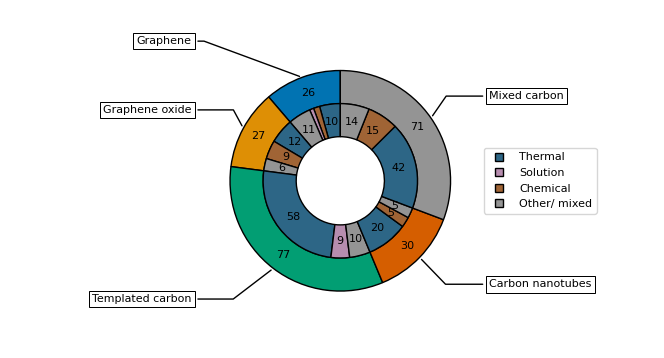

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [26]:
mixed_carbon_totals = 0 
for keys, values in carbon_types_combined.items():
    if "+" in keys:
#         print(values)
        mixed_carbon_totals += len(values)

mixed_carbon_types = {}

for keys, values in carbon_types_combined.items():
    if "+" in keys:
        mixed_carbon_types.update([(keys, {})])
        for method_key, method_values in sulfur_loading_labels.items():
            mixed_carbon_types[keys].update([(method_key, len(
                                        excludes_keywords(cont_multi_keywords(values,
                                                                              list_of_keywords=method_values["include"],
                                                                              column="Sulfur loading method", case=False),
                                                                              list_of_keywords=method_values["exclude"],
                                                                              column="Sulfur loading method", case=False)
                                                                                                 ))])

mixed_addition = dict([(keys, np.sum([values[keys] for values in mixed_carbon_types.values()]))
                       for keys in sulfur_loading_labels.keys()])

## Making a dictionary with:
## {carbon_type_key: 
##                  {loading_key_1: <int>,
##                   loading_key_2: <int>, ...}

method_by_carbon = {}

for carbon_key, carbon_values in carbon_data.items():
    method_by_carbon.update([(carbon_key, {})])
    for method_key, method_values in sulfur_loading_labels.items():
        method_by_carbon[carbon_key].update([(method_key, len(
        excludes_keywords(cont_multi_keywords(carbon_values,
                                              list_of_keywords=method_values["include"],
                                              column="Sulfur loading method", case=False),
                          list_of_keywords=method_values["exclude"],
                          column="Sulfur loading method", case=False)
                                             ))])
        

## Only 'single' methods are included above (i.e. thermal OR chemical OR solution)
## Adding 'other' category for remaining data
for carbon_key, carbon_values in carbon_data.items():
    total_entries = len(carbon_values)
    included_entries = np.sum([*method_by_carbon[carbon_key].values()])
    method_by_carbon[carbon_key].update([("Other/ mixed", 
                                          total_entries-included_entries)])
    
method_by_carbon.update([("Mixed carbon", 
                          mixed_addition)])
method_by_carbon["Mixed carbon"].update([("Other/ mixed", mixed_carbon_totals-np.sum([*method_by_carbon["Mixed carbon"].values()]))])

from copy import deepcopy
method_by_carbon_mod = deepcopy(method_by_carbon)
method_by_carbon_mod.pop("Reduced graphene oxide")

methods_concat_values_all = np.hstack([[*values.values()] for values in method_by_carbon_mod.values()])
methods_concat_keys_all = np.hstack([[*values.keys()] for values in method_by_carbon_mod.values()])
methods_concat_colors_all = np.array([colors_infiltration[keys] for keys in methods_concat_keys_all])

methods_concat_values = methods_concat_values_all[methods_concat_values_all>0]
methods_concat_keys = methods_concat_keys_all[methods_concat_values_all>0]
methods_concat_colors = methods_concat_colors_all[methods_concat_values_all>0]

start_angle = 90
self = PieOuterLabels()
self.set_outer_pie([np.sum([*values.values()]) for keys, values in method_by_carbon_mod.items()],
                   pie_labels=[keys for keys, values in method_by_carbon_mod.items()],
                   color=[carbon_types_colors[key] for key in method_by_carbon_mod.keys()],
                   start_angle=start_angle, fontsize=font_size)

self.set_inner_pie(methods_concat_values, pie_labels=methods_concat_keys, 
                   color=list(methods_concat_colors), legend_labels=False,
                    min_label=3, start_angle=start_angle, fontsize=font_size)
for keys, values in colors_infiltration.items():
    if "+" not in keys:
        self.ax.plot([], [], "s", mfc=values, mec="k", label=keys)
self.ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


self.fig.set_size_inches(full_width_figsize)
plt.savefig(os.path.join(save_path, "png", "5_Sulfur_method_by_carbon.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "5_Sulfur_method_by_carbon.eps"), bbox_inches="tight")

## Quantity of sulfur in carbon/ sulfur composite, sorted by carbon type

<IPython.core.display.Javascript object>


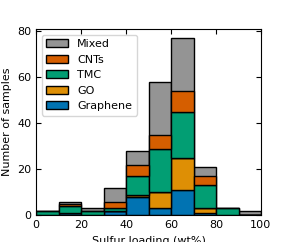

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [28]:
sulfur_loading_by_carbon = dict([(keys, values.loc[values['Sulfur loading (wt%)']!=""]["Sulfur loading (wt%)"].to_numpy(dtype=float))
                                 for keys, values in carbon_data.items()])
sulfur_wtpc_x = np.linspace(0, 100, 11)

sulfur_wtpc_available = available_data.loc[available_data["Sulfur loading (wt%)"] != ""]
sulfur_wtpc = sulfur_wtpc_available["Sulfur loading (wt%)"].to_numpy(dtype=float)

sulfur_wtpc_y_total = [np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[xi]) & (sulfur_wtpc<sulfur_wtpc_x[xi+1]))[0].shape[0] for xi in range(sulfur_wtpc_x.shape[0]-1)]+[np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[-1]))[0].shape[0]]

sulfur_wtpc_y = dict([(keys, 
                       [np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[xi]) & (sulfur_wtpc<sulfur_wtpc_x[xi+1]))[0].shape[0] for xi in range(sulfur_wtpc_x.shape[0]-1)]+[np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[-1]))[0].shape[0]])
                     for keys, sulfur_wtpc in sulfur_loading_by_carbon.items()])

f, ax_wtpc = plt.subplots(figsize=half_width_figsize)
ax_wtpc.bar(sulfur_wtpc_x-0.5*(sulfur_wtpc_x[1]-sulfur_wtpc_x[0]),
       sulfur_wtpc_y_total, width=10, color=carbon_types_colors["Mixed carbon"], edgecolor="k", label="Mixed carbon")
for n in range(len(sulfur_wtpc_y)):
    ax_wtpc.bar(sulfur_wtpc_x-0.5*(sulfur_wtpc_x[1]-sulfur_wtpc_x[0]),
           [*sulfur_wtpc_y.values()][n],
           bottom=np.sum([*sulfur_wtpc_y.values()][:n], axis=0), width=10, color=carbon_types_colors[[*sulfur_loading_by_carbon.keys()][n]],
           edgecolor="k",
           label=[*sulfur_loading_by_carbon.keys()][n])
    
ax_wtpc.legend()

handles, labels = ax_wtpc.get_legend_handles_labels()
label_sort = ["Graphene", "Graphene oxide", 
              #"Reduced graphene oxide", 
              "Templated carbon", "Carbon nanotubes", "Mixed carbon"][::-1]

label_sort_short = [short_name_labels[key] for key in label_sort]
# label_sort_short = ["Graphene", "GO", # "RGO",
#                     "MC", "CNTs", "Mixed"][::-1]



handle_sort = [handles[[nlabel for nlabel, label in enumerate(labels) if label==name][0]] for name in label_sort]

ax_wtpc.legend(handles=handle_sort, labels=label_sort_short, loc="upper left")

ax_wtpc.set_xlabel("Sulfur loading (wt%)")
ax_wtpc.set_ylabel("Number of samples")
ax_wtpc.set_xlim([0, 100])

plt.savefig(os.path.join(save_path, "png", "5_Bars_Sulfur_loading_by_host_type.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "5_Bars_Sulfur_loading_by_host_type.eps"), bbox_inches="tight")

<IPython.core.display.Javascript object>


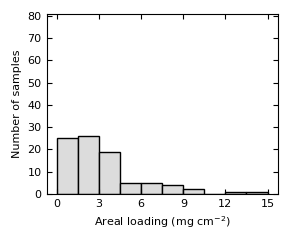

In [29]:
areal_sulfur = df.loc[df["Sulfur loading (mg/ cm2)"]!=""]
areal_sulfur = excludes_keywords(areal_sulfur, ["-"], column="Sulfur loading (mg/ cm2)")["Sulfur loading (mg/ cm2)"].to_numpy(dtype=float)
areal_x = np.linspace(0, np.ceil(np.nanmax(areal_sulfur)), 11)
width = (areal_x[1]-areal_x[0])
areal_y = [np.nonzero((areal_sulfur>=areal_x[xi]) & (areal_sulfur<areal_x[xi+1]))[0].shape[0]
          for xi in range(areal_x.shape[0]-1)]
f, ax = plt.subplots(figsize=half_width_figsize)
ax.bar(areal_x[:-1]+0.5*width, areal_y, width=width, color="gainsboro", edgecolor="k")
# ax.set_xticks(areal_x[:-1])
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Areal loading (mg cm$^{-2}$)")
ax.set_ylabel("Number of samples")
ax.set_ylim(ax_wtpc.get_ylim())
plt.tight_layout()
plt.savefig(os.path.join(save_path, "png", "5_Bars_Areal_loading_sulfur.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "5_Bars_Areal_loading_sulfur.eps"), bbox_inches="tight")

<IPython.core.display.Javascript object>


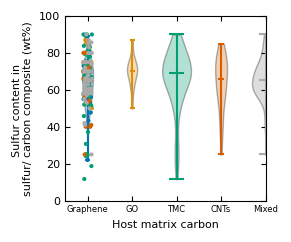

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
sulfur_loading_by_carbon = dict([(keys, 
                                  values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float)) 
                                 for keys, values in carbon_data.items()])

sulfur_loading_by_carbon.update([("Mixed carbon",
                                  np.hstack([values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float) for keys, values in carbon_types_combined.items() if "+" in keys]))])


sulfur_loading_by_carbon.pop("Reduced graphene oxide")
share_sulfur_loading_by_carbon = dict([(keys, len(values)) for keys, values in sulfur_loading_by_carbon.items()])
sulfur_loading_widths = dict([(keys, values/sum([*share_sulfur_loading_by_carbon.values()])) for keys, values in share_sulfur_loading_by_carbon.items()])

sulfur_by_carbon_nan = [values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float) for values in carbon_data.values() if len(values)>0]

labels=["Graphene", "GO", "Templated", "CNTs", "Mixed"]
label_keys = ["Graphene", "Graphene oxide", "Templated carbon", "Carbon nanotubes", "Mixed carbon"]

from copy import deepcopy
carbon_data_mod = deepcopy(sulfur_loading_by_carbon)
# carbon_data_mod.pop("Reduced graphene oxide");

fig, ax = plt.subplots(figsize=half_width_figsize)

violins = {}

for nkeys, (keys, values) in enumerate(carbon_data_mod.items()):
    violins.update([(keys, ax.violinplot(values, positions=[nkeys], showmedians=True,
                                         widths=2*sulfur_loading_widths[keys]))])
    
for keys, values in violins.items():
    for body in values["bodies"]:
        body.set_facecolor(carbon_types_colors[keys])
        body.set_edgecolor("k")
    for line in ["cmaxes", "cmins", "cbars", "cmedians"]:   
        if keys != "Mixed carbon":
            values[line].set_color(carbon_types_colors[keys])
        else:
            values[line].set_color("darkgrey")

strip_plots = {}
for nkeys, (keys, values) in enumerate(carbon_data_mod.items()):
    if keys != "Mixed carbon":
        strip_plots.update([(keys, sns.stripplot(x=[nkeys]*carbon_data_mod[keys].shape[0],
                                         y=values, jitter=True,
                                         color=carbon_types_colors[keys], size=3))])
    else:
        strip_plots.update([(keys, sns.stripplot(x=[nkeys]*carbon_data_mod[keys].shape[0],
                                         y=values, jitter=True,
                                         color="darkgrey", size=3))])
ax.set_ylim([0, 100])    
ax.set_xticks(np.arange(len(carbon_data_mod)))
ax.set_xticklabels([short_name_labels[keys] for keys in violins.keys()], rotation=0, fontsize=6/8*font_size)
ax.set_ylabel("Sulfur content in \nsulfur/ carbon composite (wt%)")
ax.set_xlabel("Host matrix carbon")
plt.tight_layout()

plt.savefig(os.path.join(save_path, "png", "5_Violin_sulfur_loading_by_carbon.png"), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "eps", "5_Violin_sulfur_loading_by_carbon.eps"), bbox_inches="tight")

In [ ]:
sulfur_loading_labels = {"Thermal": {"include": ["thermal"],
                                     "exclude": ["solution", "chemical"]},
                         "Chemical": {"include": ["Chemical", "Na2S2O3"],
                                    "exclude": ["thermal", "CS2"]},
                         "Solution": {"include": ["CS2", "solvent", "toluene"],
                                      "exclude": ["thermal"]}}

sulfur_loading = dict([(keys, cont_multi_keywords(df=excludes_keywords(df=available_data,
                                 list_of_keywords=values["exclude"],
                                 column="Sulfur loading method",
                                 case=False),
                                                 list_of_keywords=values["include"],
                                                 column="Sulfur loading method",
                                                  case=False)) for keys, values in sulfur_loading_labels.items()])

sulfur_loading_inclusive = dict([(keys, cont_multi_keywords(df=available_data,
                                                 list_of_keywords=values["include"],
                                                 column="Sulfur loading method",
                                                  case=False)) for keys, values in sulfur_loading_labels.items()])

merge_columns = [name for name in available_data.columns if "Scanned data" not in name]

sulfur_loading_combined = {}
for nk1, key_1 in enumerate(sulfur_loading_inclusive.keys()):
    for nk2, key_2 in enumerate(sulfur_loading_inclusive.keys()):
        if nk1 < nk2:
            sulfur_loading_combined.update([("+\n".join((key_1, key_2)),
                                             pd.merge(sulfur_loading_inclusive[key_1][merge_columns],
                                                      sulfur_loading_inclusive[key_2][merge_columns]))])
            
sulfur_loading_combined = dict([(keys, values) for keys, values in sulfur_loading_combined.items() if len(values)>0])
sulfur_loading_total = {**sulfur_loading, **sulfur_loading_combined}
method_XRD = dict([(name, {"Present": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n==True]),
              "Absent": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n==False]),
              "No data": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n!=True and n!=False])})
       for name in sulfur_loading_total.keys()])
# ax.set_prop_cycle("color", [*c.saturation(70, scheme=["Mid Green", "Yellow", "Mid Red", "Dark Purple", "Dark Blue", "Mid Blue", "Grey"]).values()]+["white"])

method_XRD = {"Solution": method_XRD["Solution"],
            "Thermal+\nSolution": method_XRD["Thermal+\nSolution"],
            "Thermal": method_XRD["Thermal"],
              "Thermal+\nChemical": method_XRD["Thermal+\nChemical"],
              "Chemical": method_XRD["Chemical"],}

sulfur_content_by_method = dict([(keys, [float(x) for x in values["Sulfur loading (wt%)"] if len(x)>0]) for keys, values in sulfur_loading.items()])
sulfur_content_by_method_combined = dict([(keys, [float(x) for x in values["Sulfur loading (wt%)"] if len(x)>0]) for keys, values in sulfur_loading_combined.items()])

sulfur_content_by_method.update([(keys, values) for keys, values in sulfur_content_by_method_combined.items()])

sulfur_content_totals = [len(values) for values in sulfur_content_by_method.values()]
widths = [x/np.sum(sulfur_content_totals) for x in sulfur_content_totals]

f, ax = plt.subplots(figsize=half_width_figsize)
violin_plot = {}
strip_plot = {}

for nkeys, (keys, values) in enumerate(sulfur_content_by_method.items()):
    violin_plot.update([(keys, ax.violinplot(sulfur_content_by_method[keys], 
                                             positions=[nkeys], showmedians=True,
                                             widths=widths[nkeys]))])
    strip_plot.update([(keys, sns.stripplot(y=sulfur_content_by_method[keys],
                                            x=len(sulfur_content_by_method[keys])*[nkeys], jitter=True,
                                           color=colors_infiltration[keys], size=3),
                                            
                        )])
    
for keys, values in violin_plot.items():
    for body in values["bodies"]:
        body.set_facecolor(colors_infiltration[keys])
        body.set_edgecolor("k")
    for line in ["cmaxes", "cmins", "cbars", "cmedians"]:   
        values[line].set_color(colors_infiltration[keys])
            
ax.set_xticks(np.arange(len(sulfur_content_by_method)))
ax.set_xticklabels(sulfur_content_by_method.keys(), rotation=0, fontsize=6/8*font_size)

ax.set_ylabel("Sulfur content in \nsulfur/ carbon composite (wt%)")
ax.set_xlabel("Composite synthesis method")

ax.set_ylim([0, 100])

plt.tight_layout()
plt.savefig(os.path.join(save_path, "png", "5_Violin_Sulfur_loading_by_method.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "5_Violin_Sulfur_loading_by_method.eps"), bbox_inches="tight")

# Sulfur loading methods: XRD results

In [ ]:
self = PieOuterLabels()
self.set_inner_pie([item for sublist in [[*values.values()] for values in method_XRD.values()] for item in sublist],
                   [item for sublist in [[*values.values()] for values in method_XRD.values()] for item in sublist],
                   color=[[*c.saturation(i, ["Grey"]).values()][0] for i in [10, 50, 100]],
                   legend_labels=False, fontsize=font_size)
self.set_outer_pie([np.sum([*values.values()]) for values in method_XRD.values()],
                   [*method_XRD.keys()],
                   color=[colors_infiltration[key] for key in method_XRD.keys()],
                   label_fliers=False, fontsize=font_size
                  )
self.ax.plot([], [], label="Sulfur loading method", ls="none")
for nkey, key in enumerate([*method_XRD.keys()]):
    self.ax.plot([], [], marker="s", label=key.replace("\n", ""), mfc=self.color[nkey], mec="k", ls="none", ms=10)
    
self.ax.plot([], [], label=" ", ls="none")
self.ax.plot([], [], label="XRD sulfur", ls="none")
for nname, name in enumerate(["S$_{8}$ present", "S$_{8}$ absent", "n.d."]):
    self.ax.plot([], [],  marker="s", label=name, mfc=[[*c.saturation(i, ["Grey"]).values()][0] for i in [10, 50, 100]][nname],
                 mec="k", ls="none", ms=10)
    
self.ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=font_size)
self.fig.set_size_inches(full_width_figsize)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "Sulfur_loading_XRD.png"), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "Sulfur_loading_XRD.eps"), bbox_inches="tight")

In [ ]:
bp[True]

In [ ]:
sulfur_areal_true = dict(df.loc[df["Sulfur loading (mg/ cm2)"]!=""])
sulfur_areal_false = dict(df.loc[df["Sulfur loading (mg/ cm2)"]==""])

sulfur_weight_true = dict(df.loc[df['Sulfur loading (wt%)']!=""])
sulfur_weight_false = dict(df.loc[df['Sulfur loading (wt%)']==""])

sulfurwtfalse_sulfurarealtrue = available_data.loc[(available_data["Sulfur loading (wt%)"] == "") & (available_data["Sulfur loading (mg/ cm2)"] != "")]
sulfurwttrue_sulfurarealfalse = available_data.loc[(available_data["Sulfur loading (wt%)"] != "") & (available_data["Sulfur loading (mg/ cm2)"] == "")]
sulfurwttrue_sulfurarealtrue = available_data.loc[(available_data["Sulfur loading (wt%)"] != "") & (available_data["Sulfur loading (mg/ cm2)"] != "")]

xrd_sort = dict([(B, dict([(keys, values.loc[values["Sulfur XRD"]==B][["Sulfur loading (wt%)", "Sulfur XRD"]]) for keys, values in carbon_data.items()]))
       for B in [True, False]])

xrd_sort.update([("n.d.", 
                  dict([(keys, values.loc[(values["Sulfur XRD"] != True) & (values["Sulfur XRD"] != False)][["Sulfur loading (wt%)", "Sulfur XRD"]])
                        for keys, values in carbon_data.items()])
                 )])

xrd_sort_float = {}

for boolkeys, boolvalues in xrd_sort.items():
    xrd_sort_float.update([(boolkeys, {})])
    for carbonkeys, carbonvalues in boolvalues.items():
        if len(carbonvalues.loc[carbonvalues["Sulfur loading (wt%)"]!=""]) >0:
            xrd_sort_float[boolkeys].update([(carbonkeys, carbonvalues.loc[carbonvalues["Sulfur loading (wt%)"]!=""]["Sulfur loading (wt%)"].to_numpy(dtype=float))])

xs = [np.full((values.shape[0]), x) for x, values in enumerate(xrd_sort_float[True].values())]

f, ax = plt.subplots(figsize=half_width_figsize)
bp = {True: ax.violinplot([list(y) for y in [*xrd_sort_float[True].values()]], 
                          widths=[len(values)/sum([len(values) for values in xrd_sort_float[True].values()]) for values in xrd_sort_float[True].values()], positions=np.arange(len(xrd_sort_float[True]))-0.25, showmedians=True),
      False: ax.violinplot([list(y) for y in [*xrd_sort_float[False].values()]], 
                           widths=[len(values)/sum([len(values) for values in xrd_sort_float[False].values()]) for values in xrd_sort_float[False].values()], positions=np.arange(len(xrd_sort_float[False])), showmedians=True),
      "n.d.": ax.violinplot([list(y) for y in [*xrd_sort_float["n.d."].values()]], 
                            widths=[len(values)/sum([len(values) for values in xrd_sort_float["n.d."].values()]) for values in xrd_sort_float["n.d."].values()], positions=np.arange(len(xrd_sort_float["n.d."]))+0.25, showmedians=True)}

ax.set_ylim([0, 100])

color_bp = {True: "cadetblue", 
            False: "goldenrod",
            "n.d.": "darkgrey"}

for key, values in color_bp.items():
    for body in bp[key]["bodies"]:
        body.set_facecolor(values)
    for line in ["cmaxes", "cmins", "cbars", "cmedians"]:
        bp[key][line].set_color(values)
        
jitter = 0.05

[ax.plot(np.full((values.shape[0]), x+jitter*np.random.rand(values.shape[0])-0.5*jitter)-0.25,
         values, ".", color=color_bp[True], label="S$_{8}$ present")  for x, values in enumerate(xrd_sort_float[True].values())]
[ax.plot(np.full((values.shape[0]), x+jitter*np.random.rand(values.shape[0])-0.5*jitter),
         values, ".", color=color_bp[False], label="S$_{8}$ absent")  for x, values in enumerate(xrd_sort_float[False].values())]
[ax.plot(np.full((values.shape[0]), x)+0.25+jitter*np.random.rand(values.shape[0])-0.5*jitter,
         values, ".", color=color_bp["n.d."], label="No XRD")  for x, values in enumerate(xrd_sort_float["n.d."].values())]
ax.set_xticks(np.arange(len(xrd_sort_float[True])))
# ax.set_xticklabels(xrd_sort_float[True].keys(), rotation=45)
ax.set_xticklabels(["Graphene", "GO", "TMC", "CNTs"])
ax.set_ylabel("Sulfur content in \nsulfur/ carbon composite (wt%)")
ax.set_xlabel("Host carbon")


handles, labels = ax.get_legend_handles_labels()
unique_labels, unique_idx = np.unique(labels, return_index=True)
unique_handles = [handles[idx] for idx in unique_idx] 

ax.legend(labels=list(unique_labels), handles=unique_handles,
          markerscale=1, ncol=1, columnspacing=0)

plt.tight_layout()

plt.savefig(os.path.join(save_path, "png", "5_Violin_plot_XRD_by_carbon_type.png"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(save_path, "eps", "5_Violin_plot_XRD_by_carbon_type.eps"), bbox_inches="tight")

# Conductive carbon additive

In [ ]:
conductive_add_names, conductive_add_counts = np.unique(available_data["Conductive additive"], return_counts=True)


conductive_add_definitions = {"None": ["0", "None", "n.d."],
                       "Acetylene black": ["Acetylene black", "Acetylene carbon black"],
                       "Carbon black (other)": ["Conductive carbon black", "conducting carbon",
                                                "Super-S carbon black", "Carbon black", "carbon black", 
                                                "Super C65", "Super C65 + Printex XE2"],
                       "Super P carbon black": ["Super-P carbon black", "Super P carbon black"],
                       "Nanofibers/ tubes": ["CNTs", "Carbon fibers with carbon nanofibers"]}

# cca_order = [*conductive_add_definitions.keys()]
cca_order = ["None", "Carbon black (other)", "Acetylene black", "Super P carbon black", "Nanofibers/ tubes"]

conductive_add_definitions = dict([(key, conductive_add_definitions[key]) for key in cca_order])

cca_sort = dict([(keys, pd.concat([df.loc[df["Conductive additive"]==name][["Conductive additive", "Conductive additive content (wt%)"]] 
 for name in values])) for keys, values in conductive_add_definitions.items()])

cca_sort["None"].loc[cca_sort["None"]["Conductive additive content (wt%)"] != '0'] = '0'

outer_pie_data = np.hstack([[np.unique(cca_sort[name]["Conductive additive content (wt%)"], return_counts=True)[1]] 
 for name in cca_sort.keys()]).flatten()
outer_pie_labels = np.hstack([[np.unique(cca_sort[name]["Conductive additive content (wt%)"], return_counts=True)[0]] 
 for name in cca_sort.keys()]).flatten()


cca_colors = {"None": "Greys",
              "Acetylene black": "Blues",
              "Carbon black (other)": "Greens",
              "Super P carbon black": "Reds",
              "Nanofibers/ tubes": "Purples"}

n_colors = dict([(name, np.unique(cca_sort[name]["Conductive additive content (wt%)"], return_counts=True)[0].shape[0])
                 for name in cca_sort.keys()])

outer_colors = [item for sublist in [[vars(plt.cm)[cca_colors[name]](i) for i in np.linspace(0.2, 0.8, n_colors[name])]
  for name in n_colors.keys()] for item in sublist]

In [ ]:
self = PieOuterLabels()

start_angle = 0
self.set_inner_pie(pie_data=[len(values) for values in cca_sort.values()],
                   pie_labels=[*cca_sort.keys()], 
                   color=[vars(plt.cm)[cca_colors[name]](0.5) for name in cca_sort.keys()],
                   start_angle=start_angle, legend_labels=False, fontsize=font_size)


## ON FIRST RUN: Comment out marked rows
## ON SUBSEQUENT RUNS: uncomment and use values from box below
self.set_outer_pie(pie_data=outer_pie_data, pie_labels=outer_pie_labels,
                   color=outer_colors, start_angle=start_angle,
                   connection_style="straight",
                   flier_y_offsets=y_flier_offsets,
                   flier_x_offsets=x_flier_offsets, 
                   fontsize=font_size
                  )
for name in cca_sort.keys():
    self.ax.plot([], [], label=name, ls="none", marker="s", mfc=vars(plt.cm)[cca_colors[name]](0.5), mec="k")
    
    
self.ax.legend(loc="center left", bbox_to_anchor=(1.2, 0.5))
self.fig.set_size_inches((a4_inches[1]*0.9, a4_inches[1]*0.9/2))

plt.savefig(os.path.join(save_path, "png", "6_Pie_Conductive_additive.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "6_Pie_Conductive_additive.eps"), bbox_inches="tight")

In [ ]:
x_flier_offsets = self.make_flier_offsets()
y_flier_offsets = self.make_flier_offsets()

y_flier_offsets['40'] = 0.1
y_flier_offsets['15_8'] = 0.1
y_flier_offsets['20_9'] = 0.1
y_flier_offsets['15_12'] = -0.1

# Binder

In [ ]:
binder_names, binder_counts = np.unique(available_data["Binder"], return_counts=True)

binder_definitions = {"None": ["0", "None", "n.d."],
                      "PVDF": ["PVDF"],
                      "Other": [name for name in binder_names if name not in ["0", "None", "n.d.", "PVDF"]]}

binder_inner = {}
for keys, values in binder_definitions.items():
    if keys != "None":
        binder_inner.update([(keys, {"content": [],
                                     "counts": []})])
        for name in values:
            content, counts = np.unique(available_data.loc[available_data["Binder"]==name]["Binder content (wt%)"],
                                        return_counts=True)

            binder_inner[keys]["content"].append(list(content))
            binder_inner[keys]["counts"].append(list(counts))            

binder_inner_sums = {}

for keys, values in binder_inner.items():
    if keys not in binder_inner_sums:
        binder_inner_sums.update([(keys, {})])
        
    unique_content = np.sort(np.unique([item for sublist in [*values["content"]] for item in sublist]))
    for un_co in unique_content:
        binder_inner_sums[keys].update([(un_co, np.sum([[item for sublist in [*values["counts"]] for item in sublist][nval]
                      for nval, val in enumerate([item for sublist in [*values["content"]] for item in sublist]) if 
                                                   val==un_co]))])

binder_outer = {}

for keys, values in binder_definitions.items():
    if keys not in binder_outer.keys():
        binder_outer.update([(keys, [])])
        
    for name in values:
        binder_outer[keys].append([binder_counts[n_b_name] for 
                                   n_b_name, b_name in enumerate(binder_names) if b_name==name][0])
binder_outer["None"] = [sum(binder_outer["None"])]

binder_inner_sums.update([("None", {"0": binder_outer["None"][0]})])

binder_inner_sums_order = dict([(keys, binder_inner_sums[keys]) for keys in binder_outer.keys()])

colors_binder = {"PVDF": "Reds",
          "Other": "Blues",
          "None": "Greys"}

colormap_binder = {}
colormap_binder_categories = {}

for keys, values in binder_inner_sums_order.items():
    colormap_binder.update([(keys, [vars(plt.cm)[colors_binder[keys]](i) for i in 
                             np.linspace(0.2, 0.9, len(values))])])
    colormap_binder_categories.update([(keys, [vars(plt.cm)[colors_binder[keys]](0.8)][0])])

In [ ]:
self = PieOuterLabels()
self.set_inner_pie([sum(values) for values in binder_outer.values()], [*binder_outer.keys()],
                   color=[*colormap_binder_categories.values()],
                  fontsize=font_size)
self.set_outer_pie([items for sublist in [list(values.values()) for values in binder_inner_sums_order.values()] for items in sublist],
                   ["{} wt%".format(items) for sublist in [list(values.keys()) for values in binder_inner_sums_order.values()] for items in sublist],
                   color=[item for sublist in [*colormap_binder.values()] for item in sublist],
                   flier_y_offsets=y_offsets,
                   fontsize=font_size
                  )
self.ax.legend(labels=[*binder_outer.keys()], loc="center left", bbox_to_anchor=(1.2, 0.5))
self.fig.set_size_inches(full_width_figsize)
plt.savefig(os.path.join(save_path, "png", "7_Pie_binder_types.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "7_Pie_binder_types.eps"), bbox_inches="tight")

In [ ]:
y_offsets = self.make_flier_offsets()
y_offsets["8 wt%"] = 0.15
y_offsets["7.5 wt%"] = 0.05

# Electrolyte solvent

In [ ]:
electrolyte_solvent_orig, electrolyte_solvent_counts = np.unique(df["Electrolyte solvent"], return_counts=True)

electrolyte_solvent = np.array(['1:1 DOL DME', '1:1 DOL TEGDME', '1:1 PYR14TFSI\n/PEGDME',
       '4:1 DOL DME', '55:40 DOL DME', 'TEGDME', 'Tetraglyme', 'n.d.'])

solvent_idx = [item for sublist in [[n for n, nname in enumerate(electrolyte_solvent_orig) if nname==value] for value in electrolyte_solvent] for item in sublist]
electrolyte_solvent_counts = [electrolyte_solvent_counts[idx] for idx in solvent_idx]
y_offsets = self.make_flier_offsets()
y_offsets["1:1 PYR14TFSI\n/PEGDME"] = -0.05
y_offsets["n.d."] = 0.5
y_offsets["1:1 DOL TEGDME"] = -0.25
y_offsets["TEGDME"] = 0.1
y_offsets["Tetraglyme"] = 0.4
x_offsets = self.make_flier_offsets()
x_offsets["1:1 DOL DME"] = 3.25
y_offsets["1:1 DOL DME"] = -0.4

self = PieOuterLabels()

self.set_outer_pie(electrolyte_solvent_counts, electrolyte_solvent, start_angle=30, connection_style="straight",
                   fontsize=font_size,
                   flier_y_offsets=y_offsets,
                   flier_x_offsets=x_offsets
                  )
self.fig.set_size_inches(full_width_figsize)


plt.tight_layout()
plt.savefig(os.path.join(save_path, "eps", "7_pie_Electrolyte_solvent.eps"), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "7_pie_Electrolyte_solvent.png"), bbox_inches="tight", dpi=200)

# Separator

In [ ]:
separator, separator_counts = np.unique(df["Separator type"], return_counts=True)

separator_dict = dict([(sep, separator_counts[nsep]) for nsep, sep in enumerate(separator)])

separator_groups = {"Celgard": ["elgard"],
                    "Fibre": ["iber", "ibre"],
                    "Other": []}

separator_dict = dict([(key, dict([(name, separator_counts[nname]) for nname, name in enumerate(separator)
                                     if any([item in name for item in separator_groups[key]])
                                    ])) for key, values in separator_groups.items()])

separator_dict.update([("Other", dict([(name, separator_counts[nname]) for nname, name in enumerate(separator)
                                       if any([item in name for item in [sub for sublist in [*separator_groups.values()] for sub in sublist]])==False
                                    ])) for key, values in separator_groups.items()])

separator_dict = dict([(key, dict([([*separator_dict[key].keys()][i], [*separator_dict[key].values()][i]) for i in
      np.argsort([*separator_dict[key].values()])[::-1]])) for key in separator_dict.keys()])

labels = [item for sublist in [[*values.keys()] for values in separator_dict.values()] for item in sublist]

try:
    labels[labels.index("")] = "n.d."
except:
    pass

all_labels = labels
all_counts = [item for sublist in [[*values.values()] for values in separator_dict.values()] for item in sublist]

selected_labels = []

for ncount, count in enumerate(all_counts):
    if count>=10:
        selected_labels.append(all_labels[ncount])
    else:
        selected_labels.append("")

In [ ]:
self = PieOuterLabels()

separator_outerpie = [np.sum([*values.values()]) for values in separator_dict.values()]
separator_innerpie = [item for sublist in [[*values.values()] for values in separator_dict.values()] for item in sublist]

self.set_inner_pie(separator_outerpie, separator_dict.keys(), 
                   color=[plt.cm.Reds(0.5), plt.cm.Blues(0.5), plt.cm.Greys(0.5)],
                   fontsize=font_size, min_label=2)
self.set_outer_pie(separator_innerpie, selected_labels, label_fliers=True, 
                   fontsize=font_size,
                   color=[plt.cm.Reds(i) for i in np.linspace(0.2, 1, len(separator_dict["Celgard"]))]+\
                           [plt.cm.Blues(i) for i in np.linspace(0.2, 1, len(separator_dict["Fibre"]))]+\
                           [plt.cm.Greys(i) for i in np.linspace(0.3, 1, len(separator_dict["Other"]))],
                  min_label=2)
self.ax.legend([*separator_dict.keys()], loc="center left", bbox_to_anchor=(1, 0.5))

for nins, ins in enumerate(self.outer_autopct):
    if nins in [17, 18,19, 20, 21, 22]:
        ins.set_color("white")
        
self.fig.set_size_inches(full_width_figsize)
plt.savefig(os.path.join(save_path, "png", "8_pie_separator_types.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "8_pie_separator_types.eps"), bbox_inches="tight")


# Lithium nitrate and voltages

In [ ]:
low_volt_LiNO3 = df.loc[df["Minimum voltage"]<1.7][["LiNO3 content", "LiNO3_units"]]
ok_volt_LiNO3 = df.loc[df["Minimum voltage"]>=1.7][["LiNO3 content", "LiNO3_units"]]

In [ ]:
## converting wt% to M
mass_LiNO3 = 68.946 ## g/mol
mass_LiTFSI = 287.09 ## g/mol

density_DOL = 1.06 ## g/cm3
density_DME = 0.868 ## g/cm3

LiNO3 = available_data.loc[(available_data["Electrolyte solvent"]=="1:1 DOL DME")
                            & (available_data["Salt content"]==1)
                            & (available_data["Electrolyte salt"]=="LiTFSI")][["LiNO3 content", "LiNO3_units"]]

LiNO3wt_pc = LiNO3.loc[LiNO3["LiNO3_units"]=="wt%"]

LiNO3_M = LiNO3.loc[LiNO3["LiNO3_units"]=="M"]["LiNO3 content"]

## all values for 1M LiTFSI in DOL DME
mass_solvent = 0.5*density_DOL*1000+0.5*density_DME*1000 ## g/L
LiNO3_combined = list(LiNO3_M)+[np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in LiNO3wt_pc["LiNO3 content"]]

# len(LiNO3_combined)==len(LiNO3)

LiNO3_content, LiNO3_counts = np.unique(LiNO3_combined, return_counts=True)

LiNO3_ranges = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
linO3_pie = []
for nr, r in enumerate(LiNO3_ranges[:-1]):
    linO3_pie.append(len([value for value in LiNO3_combined if value>LiNO3_ranges[nr] and value<=LiNO3_ranges[nr+1]]))
lino3_labels = ["None", "≤0.1 M", "0.1-0.2 M", "0.2-0.3 M", "0.3-0.4 M", 
                "0.4-0.5 M", "0.5-0.6 M", "0.5-0.6 M", "0.6-0.7 M", "0.7-0.8 M",
                 "0.8-0.9", "1 M", "1M +"]

In [ ]:
low_volt_wtpc = low_volt_LiNO3.loc[low_volt_LiNO3["LiNO3_units"]=="wt%"]["LiNO3 content"].to_numpy()
low_volt_M = list(low_volt_LiNO3.loc[low_volt_LiNO3["LiNO3_units"]=="M"]["LiNO3 content"])+[np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in low_volt_wtpc]

In [ ]:
ok_volt_wtpc = ok_volt_LiNO3.loc[ok_volt_LiNO3["LiNO3_units"]=="wt%"]["LiNO3 content"].to_numpy()
ok_volt_M = list(ok_volt_LiNO3.loc[ok_volt_LiNO3["LiNO3_units"]=="M"]["LiNO3 content"])+[np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in ok_volt_wtpc]

In [ ]:
plt.close("all")

f, (ax_ok, ax_low) = plt.subplots(2, 1, sharex=True, sharey=True)
f.set_size_inches(half_width_figsize)
ax_low.hist(low_volt_M, color="gainsboro", edgecolor="k")
ax_ok.hist(ok_volt_M, color="gainsboro", edgecolor="k")

ax_ok.yaxis.set_major_locator(MultipleLocator(20))
ax_ok.yaxis.set_minor_locator(MultipleLocator(5))

ax_low.set_xlabel("LiNO$_{3}$ concentration (M)")

plt.tight_layout()
plt.subplots_adjust(left=0.15)

ax_low.annotate("Number of samples", 
                xy=(-0.1, 1), xycoords=ax_low.transAxes, rotation=90 , va="center", ha="right")
ax_ok.annotate("Lower cutoff $\geq$ 1.7 V", xy=(0.95, 0.9), ha="right", va="top", xycoords=ax_ok.transAxes)
ax_low.annotate("Lower cutoff $<$ 1.7 V", xy=(0.95, 0.9), ha="right", va="top", xycoords=ax_low.transAxes)

plt.savefig(os.path.join(save_path, "png", "9_Histogram_LiNO3_LCV.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "9_Histogram_LiNO3_LCV.eps"), bbox_inches="tight")

In [ ]:
LiNO3_wtpc = df.loc[df["LiNO3_units"]=="wt%"]
LiNO3_wtpc["LiNO3_molconv"] = [np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in LiNO3_wtpc["LiNO3 content"]]

In [ ]:
fig, ax = plt.subplots(figsize=half_width_figsize)

_leq_01M = mpatch.Rectangle(xy=(0, 0), width=0.1, height=linO3_pie[1], facecolor="gainsboro", edgecolor="k")
_01_02M = mpatch.Rectangle(xy=(0.1, 0), width=0.1, height=linO3_pie[2], facecolor="gainsboro", edgecolor="k")
_02_03M = mpatch.Rectangle(xy=(0.2, 0), width=0.1, height=linO3_pie[3], facecolor="gainsboro", edgecolor="k")
_03_04M = mpatch.Rectangle(xy=(0.3, 0), width=0.1, height=linO3_pie[4], facecolor="gainsboro", edgecolor="k")
_1M = mpatch.Rectangle(xy=(0.955, 0), width=0.05, height=linO3_pie[-2], facecolor="gainsboro", edgecolor="k")

ax.plot([0], [linO3_pie[0]], "x", color="k")
ax.add_patch(_leq_01M)
ax.add_patch(_01_02M)
ax.add_patch(_02_03M)
ax.add_patch(_03_04M)
ax.add_patch(_1M)

ax.set_ylim([0, 100])
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel("LiNO$_{3}$ content (M)")
ax.set_ylabel("Number of samples")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "png", "9_Histogram_LiNO3.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "9_Histogram_LiNO3.eps"), bbox_inches="tight")


# Voltage ranges

In [ ]:
unique_min = np.unique(df["Minimum voltage"])
unique_max = np.unique(df["Maximum voltage"])
voltage_ranges = np.vstack((np.array(df["Minimum voltage"]), np.array(df["Maximum voltage"])))

vrange_counts = np.full((unique_min.shape[0],
                         unique_max.shape[0]), 0)

for nmin, umin in enumerate(unique_min):
    for nmax, umax in enumerate(unique_max):
        match = [nvolt for nvolt in range(voltage_ranges.shape[1]) if voltage_ranges[0, nvolt]==umin
                 and voltage_ranges[1, nvolt]==umax]
        vrange_counts[nmin, nmax] = len(match)

In [ ]:
f, ax = plt.subplots(figsize=half_width_figsize)
umin = 3
umax = 0

# colors = [plt.cm.tab20(i) for i in range(np.nonzero(vrange_counts)[0].shape[0])]
ax.set_prop_cycle("color", [*c.saturation(70, scheme=["Dark Blue"]).values()])

ax.set_xlim([0.8, 3.8])
ax.set_ylim([0, np.max(vrange_counts)+2]);

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.grid(which="minor", lw=0.2)
ax.xaxis.grid(which="major")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.grid(which="minor", lw=0.2)
ax.yaxis.grid(which="major")

lw=1.5

for umin in range(vrange_counts.shape[0]):
    for umax in range(vrange_counts.shape[1]):
        if vrange_counts[umin, umax] > 0:
            ax.errorbar(x=[np.nanmedian([unique_min[umin], unique_max[umax]])],
                        y=[vrange_counts[umin, umax]],
                        xerr=np.array([[np.nanmedian([unique_min[umin], unique_max[umax]])-unique_min[umin]],
                                      [unique_max[umax]-np.nanmedian([unique_min[umin], unique_max[umax]])]]),
                       capsize=2*lw, linewidth=lw, capthick=1.5*lw)
listar = mpatch.Rectangle(xy=(1.8, 0),
                          width=(2.8-1.8),
                          height=100,
                          facecolor=c.Blue.MidBlue[80],
                          alpha=0.2,
                          zorder=0)
ax.add_patch(listar)
ax.set_ylabel("Number of samples \n(total {} samples, {} articles)".format(np.sum(vrange_counts), 
                                                                         len(bibliography_list)))
ax.set_xlabel("Galvanostatic voltage range (V)")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "eps", "10_errbars_Voltage_ranges_LiSTAR_bounds.eps"), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "10_errbars_Voltage_ranges_LiSTAR_bounds.png"), bbox_inches="tight", dpi=200)

# CRates

In [ ]:
data_load = {}
formation_cycles = 5

formation_dict = {}

for idx in available_data.index:
    label = " ".join((available_data.iloc[idx]["First author"],
                                 available_data.iloc[idx]["Year"],
                                 available_data.iloc[idx]["Optional label"]))
    data_load.update([(label, [])])
    formation_dict.update([(label, [])])
    for fname in available_data.iloc[idx]["Scanned data"]:
        CRates = np.load(fname, allow_pickle=True)[1]
        available_rates, rates_count = np.unique(CRates[1], return_counts=True)
        formation_dict[label].append(available_rates)
        if rates_count.shape[0] == 1:
            data_load[label].append(available_rates[0])
        elif rates_count.shape[0] == 2:
            if min(rates_count) < formation_cycles:
                data_load[label].append(available_rates[np.argmax(rates_count)])

In [ ]:
all_CRates = [item for sublist in [*data_load.values()] for item in sublist]

In [ ]:
CRate_mins = [0.0,  0.08, 0.15, 0.35, 0.9, 1.8, 2.25]
CRate_maxs = [0.08, 0.15, 0.30, 0.60, 1.4, 2.2, np.inf]
CRate_names = ["< 0.1 C", "0.1 C", "0.2 C", "0.5 C", "1 C", "2 C", "> 2 C"]

In [ ]:
values_binned = [len([value for value in all_CRates if value>CRate_mins[n] and value<=CRate_maxs[n]]) for n in range(len(CRate_mins))]
CRate_values_binned = np.copy(values_binned)

In [ ]:
x_counts, y_counts = np.unique(all_CRates, return_counts=True)

In [ ]:
f, (ax_lo, ax_hi) = plt.subplots(1, 2, sharey=True, figsize=(full_width_figsize))

for ax in [ax_lo, ax_hi]:
    _0_008 = mpatch.Rectangle((0, 0), 0.08, values_binned[0], facecolor="gainsboro", edgecolor="k")
    _008_015 = mpatch.Rectangle((0.08, 0), 0.07, values_binned[1], facecolor="gainsboro", edgecolor="k")
    _015_035 = mpatch.Rectangle((0.15, 0), 0.15, values_binned[2], facecolor="gainsboro", edgecolor="k")
    _035_06 = mpatch.Rectangle((0.35, 0), 0.25, values_binned[3], facecolor="gainsboro", edgecolor="k")
    _09_14 = mpatch.Rectangle((0.9, 0), 0.5, values_binned[4], facecolor="gainsboro", edgecolor="k")
    _18_22 = mpatch.Rectangle((1.8, 0), 0.4, values_binned[5], facecolor="gainsboro", edgecolor="k")
    
    ax.add_patch(_0_008)
    ax.add_patch(_008_015)
    ax.add_patch(_015_035)
    ax.add_patch(_035_06)
    ax.add_patch(_09_14)
    ax.add_patch(_18_22)
    
    ax.plot(x_counts, y_counts, ".", color="k")

lo_lims = [0, 4.5]
hi_lims = [9.5, 10.5]
    
ax.set_ylim([0, 60])
ax_lo.set_xlim([lo_lims[0], lo_lims[1]])
ax_hi.set_xlim([hi_lims[0], hi_lims[1]])

total_width = (max(lo_lims)-min(lo_lims))+(max(hi_lims)-min(hi_lims))
target_width = 0.8
centre_margin = 0.02

lo_width = (target_width-centre_margin)*(max(lo_lims)-min(lo_lims))/total_width
hi_width = (target_width-centre_margin)*(max(hi_lims)-min(hi_lims))/total_width

pos_lo = ax_lo.get_position()
ax_lo.set_position((pos_lo.x0, pos_lo.y0, lo_width, pos_lo.height))
ax_hi.set_position((pos_lo.x0+lo_width+centre_margin,
                    pos_lo.y0, hi_width, pos_lo.height))
ax_lo.spines.right.set_visible(False)
ax_hi.spines.left.set_visible(False)

# plt.rcParams.update({"xtick.top": True})
# plt.rcParams.update({"ytick.right": True})

ax_lo.tick_params(axis="y", right=False)
ax_hi.tick_params(axis="y", left=False)

slant_width = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -slant_width), (1, slant_width)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_lo.plot([1, 1], [0, 1], transform=ax_lo.transAxes, **kwargs)
ax_hi.plot([0, 0], [1, 0], transform=ax_hi.transAxes, **kwargs)
ax_lo.set_xticks(ax_lo.get_xticks()[:-1])
ax_hi.set_xticks(ax_hi.get_xticks()[1:])

ax_lo.set_ylabel("Number of samples")
ax_lo.annotate("CRate", xy=(0.6, -0.075), xycoords=ax_lo.transAxes, va="top")

ax_lo.annotate("0.1 C", xy=(0.1, values_binned[1]), xytext=(0.3, values_binned[1]), arrowprops=dict(arrowstyle='->'), ha="left")
ax_lo.annotate("0.2 C", xy=(0.2, values_binned[2]), xytext=(0.3, 45), arrowprops=dict(arrowstyle='->'))

plt.savefig(os.path.join(save_path, "eps", "11_histogram_CRates.eps"), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "11_histogram_CRates.png"), bbox_inches="tight", dpi=200)

# Capacity results

In [ ]:
def compare_capacity(cycle_number, crate_min, crate_max, formation_cycles=5):
    capacity_dict = {}
    compare_variables = ["Sulfur loading (wt%)", "CRate", "Capacity", "Label", "yerr"]

    for key in carbon_types_combined.keys():
        capacity_dict.update([(key, dict([(key, []) for key in compare_variables]))])
        for idx in carbon_types_combined[key]["Scanned data"].index:
            for entry in carbon_types_combined[key]["Scanned data"][idx]:
                record = np.load(entry, allow_pickle=True)
                ## Records should be 3 rows x cycle columns. If saved incorrectly, may be transposed
                if record.shape[1] == 3:
                    record = record.T
                
                first_value = np.min(np.argwhere(np.isfinite(record[-1])))
                crates = record[1]
                unique_rates, rate_counts = np.unique(crates, return_counts=True)
                if unique_rates.shape[0] == 2 and rate_counts[np.argmin(unique_rates)] < formation_cycles:
                    crate_use = np.max(unique_rates)
                elif unique_rates.shape[0] == 1:
                    crate_use = unique_rates[0]
                    
                if crate_use>crate_min and crate_use<=crate_max:
                    if type(cycle_number) == int and cycle_number<record.shape[1]:
                        capacity_dict[key]["Capacity"].append(record[-1][first_value+cycle_number])
                    elif type(cycle_number) == list:
                        cyc_cap = [np.nan, np.nan]
                        for ncyc, cyc in enumerate(cycle_number):
                            if cyc<record.shape[1]:
                                
                                cyc_cap[ncyc] = record[-1][first_value+cyc]
                        capacity_dict[key]["Capacity"].append(np.nanmedian(cyc_cap))
                        capacity_dict[key]["yerr"].append(cyc_cap[::-1])
                        
                    try:
                        capacity_dict[key]["Sulfur loading (wt%)"].append(float(carbon_types_combined[key]["Sulfur loading (wt%)"][idx]))
                    except:
                        capacity_dict[key]["Sulfur loading (wt%)"].append(np.nan)
                    capacity_dict[key]["CRate"].append(crate_use)
                    capacity_dict[key]["Label"].append(" ".join((carbon_types_combined[key]["First author"][idx],
                                                            carbon_types_combined[key]["Year"][idx],
                                                            carbon_types_combined[key]["Optional label"][idx])))   
        capacity_dict[key]["yerr"] = abs(np.array(capacity_dict[key]["yerr"]).T-capacity_dict[key]["Capacity"])
    return capacity_dict


def make_mixed_carbon_capacity(compare_capacity_output, filter_high=True):
    capacity_plot = dict([(keys, values) for keys, values in compare_capacity_output.items()
                          if "+" not in keys
                          and len(values["Capacity"])>0])
    
    
    mixed_data_dicts = [values for keys, values in compare_capacity_output.items() 
                        if "+" in keys 
                        if len(values["Capacity"])>0] 
    mixed_carbon_data = {}
    
    try:
        for keys in mixed_data_dicts[0].keys():
            mixed_carbon_data.update([(keys, np.hstack([subvalues[keys] for subvalues in mixed_data_dicts]))])

        capacity_plot.update([("Mixed carbon", mixed_carbon_data)])   
        
    except:
        pass
    
    if filter_high==True:
        capacity_dict_filtered = {}

        for host_key, host_value in capacity_plot.items():
            capacity_dict_filtered.update([(host_key, {})])
            max_capacity = np.array(host_value["Capacity"])+host_value["yerr"][0, :]

            retain_idx = [nvalue for nvalue, values in enumerate(max_capacity) if values < 1675]

            for feature_key, feature_value in host_value.items():
                if feature_key != "yerr":
                    capacity_dict_filtered[host_key].update([(feature_key,
                                                          [feature_value[idx] for idx in retain_idx])])
                capacity_dict_filtered[host_key].update([("yerr", 
                                                        np.vstack([host_value["yerr"][:, idx] for idx in retain_idx]).T)])
                
        return capacity_dict_filtered
    
    else:
        return capacity_plot

In [ ]:
capacity_01 = make_mixed_carbon_capacity(compare_capacity([0, 10], 0.05, 0.15))
capacity_02 = make_mixed_carbon_capacity(compare_capacity([0, 10], 0.15, 0.25))
capacity_05 = make_mixed_carbon_capacity(compare_capacity([0, 10], 0.4, 0.6))
capacity_1 = make_mixed_carbon_capacity(compare_capacity([0, 10], 0.8, 1.2))
capacity_2 = make_mixed_carbon_capacity(compare_capacity([0, 10], 1.5, 2.5))

In [ ]:
fig, ((ax01, ax02), (ax05, ax1)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(a4_inches[1]*0.8, a4_inches[1]*0.8))

for ax in [ax01, ax02, ax05, ax1]:
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 1675])
    
ax_list = [ax01, ax02, ax05, ax1]
dict_list = [capacity_01, capacity_02, capacity_05, capacity_1]
label_list = ["0.1 C", "0.2 C", "0.5 C", "1C"]

mod_labels = {'Graphene': "Graphene",
              'Graphene oxide': "GO",
              'Templated carbon': "TMC",
              'Carbon nanotubes': "CNT",
              'Mixed carbon': "Mixed"}

carbon_types_labels = {"Graphene": "h", 
                       "Graphene oxide": "v",
                       "Templated carbon": "s",
                       "Carbon nanotubes": "o",
                       "Mixed carbon": "x"}

for nax, ax in enumerate(ax_list):
    for material_key, material_values in dict_list[nax].items():
        ax.errorbar(material_values["Sulfur loading (wt%)"], material_values["Capacity"], ls="none",
                yerr=material_values["yerr"], ecolor=carbon_types_colors[material_key])
        ax.plot(material_values["Sulfur loading (wt%)"], material_values["Capacity"]+material_values["yerr"][0, :], 
               marker=carbon_types_labels[material_key], ls="none", color=carbon_types_colors[material_key], label=mod_labels[material_key])
    ax.annotate(label_list[nax], xy=(0.1, 0.9), xycoords=ax.transAxes)
        
ax_list[0].legend(ncol=5, loc="lower center", bbox_to_anchor=(1, 1))

plt.subplots_adjust(hspace=0.05, wspace=0.1)

ax_list[2].annotate("Gravimetric capacity at cycles 1 and 10 (mAh g$^{-1}$)", (-0.2, 1),
                    xycoords=ax_list[2].transAxes, rotation=90, va="center", ha="center")
ax_list[2].annotate("Sulfur loading in composite (wt%)", (1, -0.1),
                    xycoords=ax_list[2].transAxes, ha="center")

plt.savefig(os.path.join(save_path, "png", "13_Capacity_cycles_1_10_2x2.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "13_Capacity_cycles_1_10_2x2.eps"), bbox_inches="tight")

In [ ]:
def compare_capacity(cycle_number, crate_min, crate_max, formation_cycles=5):
    capacity_dict = {}
    compare_variables = ["Sulfur loading (wt%)", "CRate", "Capacity", "Label", "yerr"]

    for key in carbon_data.keys():
        capacity_dict.update([(key, dict([(key, []) for key in compare_variables]))])
        for idx in carbon_data[key]["Scanned data"].index:
            for entry in carbon_data[key]["Scanned data"][idx]:
                record = np.load(entry, allow_pickle=True)
                ## Records should be 3 rows x cycle columns. If saved incorrectly, may be transposed
                if record.shape[1] == 3:
                    record = record.T
                
                first_value = np.min(np.argwhere(np.isfinite(record[-1])))
                crates = record[1]
                unique_rates, rate_counts = np.unique(crates, return_counts=True)
                if unique_rates.shape[0] == 2 and rate_counts[np.argmin(unique_rates)] < formation_cycles:
                    crate_use = np.max(unique_rates)
                elif unique_rates.shape[0] == 1:
                    crate_use = unique_rates[0]
                    
                if crate_use>crate_min and crate_use<=crate_max:
                    if type(cycle_number) == int and cycle_number<record.shape[1]:
                        capacity_dict[key]["Capacity"].append(record[-1][first_value+cycle_number])
                    elif type(cycle_number) == list:
                        cyc_cap = [np.nan, np.nan]
                        for ncyc, cyc in enumerate(cycle_number):
                            if cyc<record.shape[1]:
                                
                                cyc_cap[ncyc] = record[-1][first_value+cyc]
                        capacity_dict[key]["Capacity"].append(np.nanmedian(cyc_cap))
                        capacity_dict[key]["yerr"].append(cyc_cap[::-1])
                        
                    try:
                        capacity_dict[key]["Sulfur loading (wt%)"].append(float(carbon_data[key]["Sulfur loading (wt%)"][idx]))
                    except:
                        capacity_dict[key]["Sulfur loading (wt%)"].append(np.nan)
                    capacity_dict[key]["CRate"].append(crate_use)
                    capacity_dict[key]["Label"].append(" ".join((carbon_data[key]["First author"][idx],
                                                            carbon_data[key]["Year"][idx],
                                                            carbon_data[key]["Optional label"][idx])))   
        capacity_dict[key]["yerr"] = abs(np.array(capacity_dict[key]["yerr"]).T-capacity_dict[key]["Capacity"])
    return capacity_dict

In [ ]:
capacity_01 = compare_capacity([0, 10], 0.05, 0.15)
capacity_02 = compare_capacity([0, 10], 0.15, 0.25)
capacity_05 = compare_capacity([0, 10], 0.4, 0.6)
capacity_1 = compare_capacity([0, 10], 0.8, 1.2)
capacity_2 = compare_capacity([0, 10], 1.5, 2.5)

colors = [*c.saturation(100, scheme=["Mid Green", "Bright Red", "Dark Blue", "Grey", "Dark Purple", "Dark Blue",  "Grey"]).values()]

colors = [carbon_types_colors[name] for name in capacity_01.keys()]

In [ ]:
def capacity_decline(decline_pc, CRate_min=None, CRate_max=None):
    capacity_dict = {}
    compare_variables = ["Sulfur loading (wt%)", "CRate", "Label", "Max capacity", "Cycles to decline", "Last cycle", "Last capacity", "In range"]

    if CRate_min == None:
        CRate_min = 0
    if CRate_max == None:
        CRate_max = 999
        
    for key in carbon_types_combined.keys():
        capacity_dict.update([(key, dict([(key, []) for key in compare_variables]))])
        for idx in carbon_types_combined[key]["Scanned data"].index:
            for nentry, entry in enumerate(carbon_types_combined[key]["Scanned data"][idx]):
                record = np.load(entry, allow_pickle=True)
                if record.shape[1] == 3:
                    record = record.T
                
                crates = record[1]
                
                unique_rates, rate_counts = np.unique(crates, return_counts=True)
                if unique_rates.shape[0] == 1 and unique_rates[0]<CRate_max and unique_rates[0]>CRate_min:
                    record_filtered = np.full((record.shape[1]), np.nan)
                    d_cap = record[-1][np.isfinite(record[-1])][1:]-record[-1][np.isfinite(record[-1])][:-1]
                    no_spike = np.nonzero((d_cap > np.nanmean(d_cap)-np.nanstd(d_cap)) & (d_cap < np.nanmean(d_cap)+np.std(d_cap)))

                    record_filtered[no_spike] = record[-1][no_spike]
                    if np.argwhere(np.isfinite(record_filtered)).shape[0] > record_filtered.shape[0]/2:
                    
                        first_value = np.min(np.argwhere(np.isfinite(record_filtered)))
                        last_value = np.max(np.argwhere(np.isfinite(record_filtered)))

                        high_capacity = np.nanmax(record_filtered)
                        min_capacity = (decline_pc/100)*high_capacity
                        min_capacity_idx = first_value+np.argmin(abs(record_filtered[first_value:]-min_capacity))

                        capacity_dict[key]["Sulfur loading (wt%)"].append(carbon_types_combined[key]["Sulfur loading (wt%)"][idx])
                        capacity_dict[key]["CRate"].append(unique_rates[0])
                        capacity_dict[key]["Label"].append(" ".join((carbon_types_combined[key]["First author"][idx],
                                                                     carbon_types_combined[key]["Year"][idx],
                                                                     carbon_types_combined[key]["Optional label"][idx])))
                        capacity_dict[key]["Max capacity"].append(high_capacity)
                        capacity_dict[key]["Cycles to decline"].append(min_capacity_idx)
                        capacity_dict[key]["Last cycle"].append(last_value-first_value)
                        capacity_dict[key]["Last capacity"].append(record_filtered[last_value])
                        if min_capacity_idx >= last_value-first_value:
                            capacity_dict[key]["In range"].append(False)
                        else:
                            capacity_dict[key]["In range"].append(True)
    return capacity_dict

In [ ]:
cap_dec_01 = capacity_decline(80, 0.05, 0.15)
cap_dec_02 = capacity_decline(80, 0.15, 0.25)
cap_dec_05 = capacity_decline(80, 0.4, 0.6)
cap_dec_1 = capacity_decline(80, 0.8, 1.2)
cap_dec_2 = capacity_decline(80, 1.5, 2.5)

In [ ]:
cap_dec_dict = cap_dec_02

def combine_cap_dec(cap_dec_dict):
    combined_dict = dict([(keys, values) for keys, values in cap_dec_dict.items() if "+" not in keys if len(values["CRate"])>0])
    
    try:
        mixed_carbons = dict([(parameter, np.hstack([values[parameter] for keys, values in 
                                                     cap_dec_dict.items() if "+" in keys])) 
                              for parameter in [*cap_dec_dict.values()][0].keys()])
        mixed_carbons["In range"] = np.array(mixed_carbons["In range"], dtype=bool)
    
        combined_dict.update([("Mixed carbon", mixed_carbons)])
        
    except:
        pass
    return combined_dict
#     return mixed_carbons

In [ ]:
cap_dec_01_mod = combine_cap_dec(cap_dec_01)
cap_dec_02_mod = combine_cap_dec(cap_dec_02)
cap_dec_05_mod = combine_cap_dec(cap_dec_05)
cap_dec_1_mod = combine_cap_dec(cap_dec_1)
cap_dec_2_mod = combine_cap_dec(cap_dec_2)

In [ ]:
sample_counts = [[len(rate_dict[material_key]["Cycles to decline"]) for material_key in rate_dict.keys()]
 for rate_dict in [cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]]
sample_counts_max = np.max(np.array([item for sublist in sample_counts for item in sublist]))

sample_counts_dict = dict([(keys, np.array([i/sample_counts_max for i in values]))
                            for keys, values in enumerate(sample_counts)])
# sample_counts = np.array([item for sublist in sample_counts for item in sublist])
# count_width = [i/np.max(sample_counts) for i in sample_counts]
# [[rate_idx for rate_idx, rate_dict in  enumerate([cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod])]

In [ ]:
vp

In [ ]:
rate_dict_list = [cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]
collected_decline = np.hstack([np.array(item, dtype=int) for sublist in [[values["Cycles to decline"][values["In range"]==True] for keys, values in rate_dict.items()] for rate_dict in rate_dict_list] for item in sublist])

In [ ]:
unique_decline, decline_counts = np.unique(collected_decline, return_counts=True)

In [ ]:
np.sum(decline_counts[unique_decline<=20])/np.sum(decline_counts)

In [ ]:
f, ax = plt.subplots()
width_scale = 1/3
jitter=0.03

# for rate_idx, rate_dict in enumerate([cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]):
#     for nmat, (material_key, material_values) in enumerate(rate_dict.items()):
#         if len(material_values["Cycles to decline"]) > 0:
#             vp = ax.violinplot(material_values["Cycles to decline"], positions=[rate_idx-0.3+nmat/6],
#                           widths=width_scale*sample_counts_dict[rate_idx][nmat])
#             for body in vp["bodies"]:
#                 body.set_facecolor(carbon_types_colors[material_key])
#             for edge in ["cmaxes", "cmins", "cbars"]:
#                 vp[edge].set_color(carbon_types_colors[material_key])
                
for rate_idx, rate_dict in enumerate([cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]):

    for nmat, (key, mat) in enumerate(rate_dict.items()):

        in_range_true = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==True]
        in_range_false = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==False]
        try:
            ax.plot(np.full((len(in_range_true)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_true))-0.5*jitter, in_range_true, ".", mfc=carbon_types_colors[key], mec=carbon_types_colors[key], label=key)
            ax.plot(np.full((len(in_range_false)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_false))-0.5*jitter, in_range_false, ".", mfc="white", mec=carbon_types_colors[key])
        except:
            pass
        
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["0.1", "0.2", "0.5", "1", "2"])

handles, labels = ax.get_legend_handles_labels()
unique_labels, unique_idx = np.unique(labels, return_index=True)

ax.legend(handles=[handles[idx] for idx in unique_idx],
          labels=list(unique_labels))
ax.set_xlabel("C Rate")
ax.set_ylabel("Cycles to 80% capacity retention")

ax.set_ylim([0, 40])

[ax.axvline(n+0.55, 
            lw=0.5, color="grey") for n in range(5)]

plt.savefig(os.path.join(save_path, "eps", "13_Scatter_capacity_80pc_retained_short_y.eps".format(jitter)), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "13_Scatter_capacity_80pc_retained_short_y.png".format(jitter)), bbox_inches="tight", dpi=200)

In [ ]:
f, ax = plt.subplots(figsize=full_width_figsize)
jitter = 0.05

for rate_idx, rate_dict in enumerate([cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]):

    for nmat, (key, mat) in enumerate(rate_dict.items()):

        in_range_true = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==True]
        in_range_false = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==False]
        try:
            ax.plot(np.full((len(in_range_true)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_true))-0.5*jitter, in_range_true, ".", mfc=carbon_types_colors[key], mec=carbon_types_colors[key], label=key)
            ax.plot(np.full((len(in_range_false)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_false))-0.5*jitter, in_range_false, ".", mfc="none", mec=carbon_types_colors[key])
        except:
            pass
   
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["0.1", "0.2", "0.5", "1", "2"])

handles, labels = ax.get_legend_handles_labels()
unique_labels, unique_idx = np.unique(labels, return_index=True)

ax.legend(handles=[handles[idx] for idx in unique_idx],
          labels=list(unique_labels))
ax.set_xlabel("C Rate")
ax.set_ylabel("Cycles to 80% capacity retention")

# ax.set_ylim([0, 20])

[ax.axvline(n+0.55, 
            lw=0.5, color="grey") for n in range(5)]

# ax.set_ylim([0, 20])
plt.savefig(os.path.join(save_path, "eps", "13_Scatter_capacity_80pc_retained_jitter{}_full_y.eps".format(jitter)), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "13_Scatter_capacity_80pc_retained_jitter{}_full_y.png".format(jitter)), bbox_inches="tight", dpi=200)

In [ ]:
f, ax = plt.subplots(figsize=full_width_figsize)
jitter = 0.05

for rate_idx, rate_dict in enumerate([cap_dec_01_mod, cap_dec_02_mod, cap_dec_05_mod, cap_dec_1_mod, cap_dec_2_mod]):

    for nmat, (key, mat) in enumerate(rate_dict.items()):

        in_range_true = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==True]
        in_range_false = [mat["Cycles to decline"][nb] for nb, b in enumerate(mat["In range"]) if b==False]
        try:
            ax.plot(np.full((len(in_range_true)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_true))-0.5*jitter, in_range_true, ".", mfc=carbon_types_colors[key], mec=carbon_types_colors[key], label=key)
            ax.plot(np.full((len(in_range_false)), rate_idx-0.3+nmat/6)+jitter*np.random.rand(len(in_range_false))-0.5*jitter, in_range_false, ".", mfc="none", mec=carbon_types_colors[key])
        except:
            pass
   
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["0.1", "0.2", "0.5", "1", "2"])

handles, labels = ax.get_legend_handles_labels()
unique_labels, unique_idx = np.unique(labels, return_index=True)

ax.legend(handles=[handles[idx] for idx in unique_idx],
          labels=list(unique_labels))
ax.set_xlabel("C Rate")
ax.set_ylabel("Cycles to 80% capacity retention")

[ax.axvline(n+0.55, 
            lw=0.5, color="grey") for n in range(5)]

ax.set_ylim([0, 25])
plt.savefig(os.path.join(save_path, "eps", "13_Scatter_capacity_80pc_retained_jitter{}_short_y.eps".format(jitter)), bbox_inches="tight")
plt.savefig(os.path.join(save_path, "png", "13_Scatter_capacity_80pc_retained_jitter{}_short_y.png".format(jitter)), bbox_inches="tight", dpi=200)

# Rate change

In [ ]:
import plotly.graph_objects as go ## To make Sankey type diagram

In [ ]:
all_samples_n = []

for nentry, entry in enumerate(available_data["Scanned data"]):
    for fname in entry:
        try:
            cycles, rates, capacities = np.load(fname)
            all_samples_n.append(capacities)
        except:
            pass
        
formation = 2

formation_data = {}

for nentry, entry in enumerate(available_data["Scanned data"]):
    for fname in entry:
        try:
            cycles, rates, capacities = np.load(fname)
        except:
            pass
        unique_rates, unique_counts = np.unique(rates, return_counts=True)
        if len(unique_rates) == formation:
            formation_data.update([(available_data.iloc[nentry]["concat_label"],
                                    rates)])
            
#         beyond_formation = [unique_rates[n] for n, ncounts in enumerate(unique_counts) if ncounts>formation]
formation_rates = np.array([np.unique(values) for values in formation_data.values()])

formation = 2

multirate_data = {}

for nentry, entry in enumerate(available_data["Scanned data"]):
    for fname in entry:
        try:
            cycles, rates, capacities = np.load(fname)
        except:
            pass
        unique_rates, unique_counts = np.unique(rates, return_counts=True)
        beyond_formation = [unique_rates[n] for n, ncounts in enumerate(unique_counts) if ncounts>formation]
        if len(beyond_formation) > 2:
            multirate_data.update([(available_data.iloc[nentry]["concat_label"], rates)])
            
rate_seq = []

for keys, values in multirate_data.items():
    rate_list = [values[0]]
    for val in values[1:]:
        if val != rate_list[-1]:
            rate_list.append(val)
    rate_seq.append(rate_list)
    
max_length = np.max([len(sublist) for sublist in rate_seq])
rate_seq_pad = np.full((len(rate_seq), max_length), 0, dtype=float)
for nseq, seq in enumerate(rate_seq):
    rate_seq_pad[nseq, :len(seq)] = rate_seq[nseq]
    
col_A = np.unique(rate_seq_pad[:, 0])
col_B = np.unique(rate_seq_pad[:, 1])

nodes = {0: np.array([[n, nnum] for n, nnum in enumerate(np.unique(rate_seq_pad[:, 0]))])}

for idx in range(1, rate_seq_pad.shape[1]):
    nodes.update([(idx, np.array([[n+max(nodes[idx-1][:, 0])+1, nnum] for 
                                  n, nnum in enumerate(np.unique(rate_seq_pad[:, idx]))]))])
# nodes.update([(2, np.array([[n+max(nodes[1][:, 0])+1, nnum] for n, nnum in enumerate(np.unique(rate_seq_pad[:, 2]))]))])


source_combined = []
target_combined = []
values_combined = []
x_pos_combined = []

for col in np.arange(1, len(nodes)):
    for i in range(nodes[col-1].shape[0]):
        for j in range(nodes[col].shape[0]):
            source = nodes[col-1][i, 1]
            target = nodes[col][j, 1]
            value = np.nonzero((rate_seq_pad[:, col-1]==source) & (rate_seq_pad[:, col]==target))[0].shape[0]
            
            if value > 0 and source>0 and target>0:
                source_combined.append(int(nodes[col-1][i, 0]))
                target_combined.append(int(nodes[col][j, 0]))
                values_combined.append(value)
                x_pos_combined.append(col-1)
                
labels_combined = np.hstack(([values[:, 1] for values in nodes.values()]))
labels_mock =np.hstack(([values[:, 0] for values in nodes.values()]))

In [ ]:
e = len(source_combined)

scale = 1.1
m = "powderblue"
p = "dimgrey"
t = "black"

fig = go.Figure(go.Sankey(link=dict(source=source_combined[:e],
                                    target=target_combined[:e],
                                    value=values_combined[:e]),
                          arrangement="snap",
                          node=dict(label=labels_combined,
                                    x=scale*np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                                       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                                       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
                                        0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
                                       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 
                                      0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                                       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 
                                      0.7, 0.7, 0.7, 0.7, 0.7,
                                       0.8, 0.8, 0.8, 0.8, 0.8, 
                                       0.9, 0.9, 0.9, 0.9]),
                                    y=[0.01]*e,
                                     color=[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, 
                                            m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, p, m, m, p, p, m, t, m, p, m, m, m, m, 
                                            t, t, p, p, p, t, p, m, m, p, p, m, m, p, m, 
                                            t, t, t, p, t, p, m, m, m, m, t, p, t, p, p,
                                            p, p, t, p, t, m, m, t, p, p,
                                            p, t, t, m, m, m,
                                             t, t, m, m, m, m,
                                            t, t, t, t, t
                                           ]
                                   )))
# fig.show()
fig.update_layout(
    autosize=False,
    width=1800,
    height=900, font_size=20
)

# Rare reports

In [ ]:
## Electrolyte content

reported_ES_ratio = available_data.loc[available_data["E/S ratio (uL/g)"] != 0][["First author", "Year", "Optional label", "E/S ratio (uL/g)"]]
ES_values = [" ".join((reported_ES_ratio["First author"][i],
                       reported_ES_ratio["Year"][i],
                       reported_ES_ratio["Optional label"][i]))
            for i in reported_ES_ratio.index]

reported_electrolyte = available_data.loc[available_data["Electrolyte volume (uL)"]!=0][["First author", "Year", "Optional label", "Electrolyte volume (uL)"]]

electrolyte_vol_values = [" ".join((reported_electrolyte["First author"][i],
                                    reported_electrolyte["Year"][i],
                                    reported_electrolyte["Optional label"][i]))
                         for i in reported_electrolyte.index]

electrolyte_content_reported = np.unique(ES_values+electrolyte_vol_values)

## Thickness

reported_thickness_value = excludes_keywords(available_data, list_of_keywords=["NaN"], column="Electrode thickness")[["First author", "Year", "Optional label", "Electrode thickness"]]

thickness_reported_values = [" ".join((reported_thickness_value["First author"][i], 
           reported_thickness_value["Year"][i],
           reported_thickness_value["Optional label"][i]))
for i in reported_thickness_value.index if len(reported_thickness_value["Electrode thickness"][i])>0]

np.unique(thickness_reported_values).shape[0]/len(bibliography_list)

## Reported surface area
reported_area_value = [re.findall("\d+.\d+", value) for value in 
                       list(available_data["Surface area (cm2/g)"]) if type(value)==str and
                       len(re.findall("\d+.\d+", value))>0]

area_reported_values = [" ".join((name for name in 
                                  list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
                        for nnumber, number in enumerate(reported_area_value)]

np.unique(area_reported_values).shape[0]/len(bibliography_list)

## Reported porosity

reported_pore_volume = [re.findall("\d+.\d+", value) for value in 
                        list(available_data["Pore volume"]) if type(value)==str
                        and len(re.findall("\d+.\d+", value))>0]

pore_volume_papers = [" ".join((name for name in list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
 for nnumber, number in enumerate(reported_pore_volume)]

np.unique(pore_volume_papers).shape[0]/len(bibliography_list)

## Reported conductivity

reported_conductivity = [re.findall("\d+.\d+", value) for value in list(available_data["Host conductivity"]) if type(value)==str and len(re.findall("\d+.\d+", value))>0]
reported_conductivity_papers = [" ".join((name for name in list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
                                for nnumber, number in enumerate(reported_conductivity)]

np.unique(reported_conductivity_papers).shape[0]/len(bibliography_list)

area_count = np.unique(area_reported_values).shape[0]
volume_count = np.unique(pore_volume_papers).shape[0]
conductivity_count = np.unique(reported_conductivity_papers).shape[0]
thickness_count = np.unique(thickness_reported_values).shape[0]
electrolyte_count = np.unique(electrolyte_content_reported).shape[0]

plt.rcParams.update({"xtick.direction": "in"})
plt.rcParams.update({"xtick.top": True})

f, ax = plt.subplots(figsize=full_width_figsize)
bar_widths = [area_count, volume_count, electrolyte_count, thickness_count, conductivity_count, ]
labels = ["BET surface area", "Pore volume", "Electrolyte content", "Electrode thickness", "Conductivity"]

ax.barh(y=np.arange(len(bar_widths)),
        width=bar_widths, color=c.BlackBrown.Grey[80], edgecolor="k")
ax.axvline(len(bibliography_list), color="k")
ax.set_yticks([])

for nname, name in enumerate(labels):
    ax.text(s=name, x=len(bibliography_list)-1, y=nname, ha="right")
    
ax.set_xlabel("Number of articles where value is reported")
ax.set_ylabel("Parameter")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))

plt.tight_layout()
plt.savefig(os.path.join(save_path, "png", "14_horizontal_bars_rare_reports.png"), bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(save_path, "eps", "14_horizontal_bars_rare_reports.eps"), bbox_inches="tight")

# Summary values
*Will only run when other code has been run!*

In [ ]:
from datetime import datetime
time_now = datetime.now()

with open(os.path.join(r"C:\Users\engs2608\OneDrive - Nexus365\Documents\Meta analysis draft - OX", 
                       "Numerical_summary_values.txt"), "w+") as f:
    f.write("Numerical outputs from meta analysis \n")
    f.write("Last updated: {}/{}/{} {}:{} \n".format(time_now.day, time_now.month, time_now.year, 
                                                  time_now.hour, time_now.minute))
    
    f.write("\n")
    f.write("Abstract \n ---------- \n")
    f.write("Total samples: {} \n".format(len(available_data)))
    f.write("Total articles: {} \n".format(len(bibliography_list)))
    
    f.write("\n")
    f.write("Introduction \n ---------- \n")
    f.write("Total articles: {} \n".format(len(bibliography_list)))
    f.write("Total samples: {} \n".format(len(available_data)))

    f.write("\n\n")
    
    f.write("Carbon host matrices \n ---------- \n")
    
    GRM_names = dict([(keys, values) for keys, values in carbon_types_combined.items() if "raphene" in keys])
    f.write("Number of articles using GRMs: {}%".format(int(np.around(np.sum([len(values) for values in GRM_names.values()])/
                                                                      np.sum([len(values) for values in carbon_types_combined.values()])*100, 0))))
    
    f.write("\n \n")
    f.write("Sulfur/ carbon composite \n ---------- \n")
    
    sulfur_content_wtpc_reported = len([n for n in available_data["Sulfur loading (wt%)"].to_numpy() if len(n) > 0])/len(available_data["Sulfur loading (wt%)"])
    f.write("Percentage of articles reporting sulfur loading in wt%: {} % \n".format(int(100*sulfur_content_wtpc_reported)))

    f.write("Percentage of articles reporting sulfur loading in mg/ cm2: {} % \n".format(
    int(100*len([n for n in df["Sulfur loading (mg/ cm2)"] if len(n) > 0])/\
        len(df["Sulfur loading (mg/ cm2)"]))))

    f.write("Number of templated carbon reports: {} \n".format(len(carbon_types_combined["Templated carbon"])))

    carbon_types_sums = dict([(keys, len(values)) for keys, values in carbon_types_combined.items()])
    f.write("Second most frequently reported host matrix: {}\n".format([*carbon_types_sums.keys()][np.argsort([*carbon_types_sums.values()])[-2]]))
    f.write("Number of CNT reports: {}".format(carbon_types_sums["Carbon nanotubes"]))
    
    
    f.write("\n \n")
    f.write("Composite synthesis method \n ---------- \n")
    sulfur_loading_method_counts = dict([(keys, len(excludes_keywords(cont_multi_keywords(df, 
                                      list_of_keywords=values["include"],
                                      column="Sulfur loading method",
                                      case=False),
                  list_of_keywords=values["exclude"],
                  column="Sulfur loading method",
                  case=False))) for keys, values in sulfur_loading_labels.items()])
    f.write("Percentage of samples using 'chemical': {}% \n".format(np.around(100*sulfur_loading_method_counts["Chemical"]/np.sum([*sulfur_loading_method_counts.values()])), 2))
    f.write("Percentage of samples using 'solution': {}% \n".format(np.around(100*sulfur_loading_method_counts["Solution"]/np.sum([*sulfur_loading_method_counts.values()])), 2))
    f.write("Percentage of samples using 'thermal': {}% \n".format(np.around(100*sulfur_loading_method_counts["Thermal"]/np.sum([*sulfur_loading_method_counts.values()])), 2))
    
    thermal_reports = excludes_keywords(cont_multi_keywords(df, list_of_keywords=["Thermal", "155"], column="Sulfur loading method"),
                  list_of_keywords=["CS2", "toluene", "solution", "mill"],
                  column="Sulfur loading method")
    thermal_and_XRD_available = np.array([n for n in thermal_reports["Sulfur XRD"] if type(n)==type(True)])
    thermal_and_XRD_true = np.nonzero(thermal_and_XRD_available==True)[0].shape[0]
    f.write("Percentage of reports where thermal infiltration used *and* crystalline sulfur detected by XRD: {} % \n".format(
int(100*thermal_and_XRD_true/thermal_and_XRD_available.shape[0])))
    
    xrd_values, xrd_counts = np.unique(df["Sulfur XRD"].to_numpy(dtype=str), return_counts=True)
    
    f.write("Percentage of samples where XRD spectra were reported: {}% \n".format(int(xrd_counts[xrd_values=='False']+xrd_counts[xrd_values=='True'])/np.sum(xrd_counts)*100))
    f.write("Percentage of reported XRD spectra showing crystalline peaks: {}% \n".format(int(100*xrd_counts[xrd_values=='True']/(xrd_counts[xrd_values=='True']+xrd_counts[xrd_values=='False']))))

    
    f.write("\n \n")
    f.write("Conductive carbon additive \n ---------- \n")
    carbon_black_used = cont_multi_keywords(available_data,
                        list_of_keywords=["black", "acetylene", "Super"], 
                       column="Conductive additive")

    f.write('Percentage using carbon black (any): {}% \n'.format(int(100*len(carbon_black_used)/len(available_data))))

    super_p_used = cont_multi_keywords(carbon_black_used,
                                   list_of_keywords=["super P", "super-P"],
                                   column="Conductive additive",
                                   case=False)
    f.write('Percentage of carbon black for which Super-P is specified: {}%\n'.format(int(len(super_p_used)/len(carbon_black_used)*100)))
    
    f.write("\n \n")
    f.write("Binder \n ---------- \n")
    

    f.write("Percentage of samples using PVDF: {} % \n".format(int(len(cont_multi_keywords(df,
                         list_of_keywords=["PVDF"], column="Binder"))/len(available_data)*100)))

    unique_content, unique_counts = np.unique(df["Binder content (wt%)"], return_counts=True)
    f.write("Percentage of samples using 10 wt%: {} % \n".format(unique_counts[unique_content=='10'].flatten()[0]/np.sum(unique_counts)*100
                                                           ))

    unique_binders, unique_binder_counts = np.unique(df["Binder"], return_counts=True)
    f.write("Number of samples using alternative binders: {} \n".format(np.sum([(unique_binder_counts[nname]) for nname, name in enumerate(unique_binders) if name not in ["PVDF", "0", "None", "n.d."]])))

    f.write("Number of samples using no binder: {} \n".format(np.sum([(unique_binder_counts[nname]) for nname, name in enumerate(unique_binders) if name in ["0", "None", "n.d."]])))

    
    f.write("\n \n")
    f.write("Electrolyte and separator \n ---------- \n")
    polypropylene_separators = cont_multi_keywords(df, 
                        list_of_keywords=["celgard", "polypropylene"],
                        column="Separator type",
                        case=False)
    f.write("Percentage using PP separators: {}% \n".format(int(len(polypropylene_separators)/len(df)*100)))

    polypropylene_celgard = cont_multi_keywords(polypropylene_separators,
                         list_of_keywords=["celgard"], 
                        column="Separator type", case=False)

    f.write("Percentage of PP separators specified as Celgard: {}% \n".format(np.around(100*len(polypropylene_celgard)/len(polypropylene_separators)), 2))

    dol_dme = cont_multi_keywords(df, list_of_keywords=["1:1 DOL DME"],
                                  column="Electrolyte solvent",
                                 )

    f.write("Percentage using DOL DME: {} % \n".format(int(len(dol_dme)/len(df)*100)))
    
    f.write("Number using glass fibre separators: {} \n".format(len(cont_multi_keywords(df, list_of_keywords=["glass"], column="Separator type", case=False)["Separator type"])))

    unique_separator, separator_counts = np.unique(df["Separator type"], return_counts=True)
    unspecified_separator = np.sum([(separator_counts[nname]) for nname, name in enumerate(unique_separator) if name in ["No data", "Unspecified", ""]])
    f.write("Percentage of samples without specified separator: {} % \n".format(int(100*unspecified_separator/len(df))))

    salt_1M_LiTFSI = df.loc[(df["Electrolyte salt"]=="LiTFSI") & (df["Salt content"] == 1) & (df["salt_units"]=="M")][["Electrolyte salt", "Salt content", "salt_units"]]
    f.write("Percentage of samples using 1M LiTFSI: {}% \n".format(int(100*len(salt_1M_LiTFSI)/len(df))))

    f.write("Percentage using LiNO3: {} % \n".format(len(df.loc[df["LiNO3 content"] != 0])/len(df)*100))
    
    f.write("\n \n")
    f.write("C Rates \n ---------- \n")
    
    
    fixed_rates = []
    formation_cycles = {"Low rate": [],
                        "Main rate": [],
                        "n low rate": [],
                        "n high rate": []}

    for nsample, sample in enumerate(available_data["Scanned data"]):
        for entry in sample:
            loaded_data = np.load(entry, allow_pickle=True)
            crates = loaded_data[1, :]
            if len(np.unique(crates)) <= 2:
                unique_rates, unique_counts = np.unique(crates, return_counts=True)
                fixed_rates.append(unique_rates[np.argmax(unique_counts)])
            if len(np.unique(crates)) == 2:
                unique_rates, unique_counts = np.unique(crates, return_counts=True)
                formation_cycles["Low rate"].append(np.min(unique_rates))
                formation_cycles["Main rate"].append(np.max(unique_rates))
                formation_cycles["n low rate"].append(unique_counts[np.argmin(unique_rates)])
                formation_cycles["n high rate"].append(unique_counts[np.argmax(unique_rates)])

    formation_cycles = pd.DataFrame(formation_cycles)
    
    fixed_rates_unique, fixed_counts = np.unique(fixed_rates, return_counts=True)
    CRate_01C = [0.07, 0.1, 0.15]
    CRate_02C = [0.16, 0.2, 0.25]

    f.write("Percentage of samples using 0.1 C: {} % \n".format(int(100*CRate_values_binned[1]/np.sum(CRate_values_binned))))
    f.write("Percentage of samples using 0.2 C: {} % \n".format(int(100*CRate_values_binned[2]/np.sum(CRate_values_binned))))
    
    f.write("Total number of cycling data sets: {}\n".format(np.sum([len(name) for name in available_data["Scanned data"]])))
    f.write("Number of samples using formation cycles: {} \n".format(len(formation_cycles)))
    f.write("Number of samples using <= 2 formation cycles: {} \n".format(len(formation_cycles.loc[formation_cycles["n low rate"]<=2])))


    compare_main_formation_rates = np.around(formation_cycles["Low rate"]/formation_cycles["Main rate"], 1)
    unique_rates, unique_counts = np.unique(compare_main_formation_rates, return_counts=True)

    f.write("Number of samples using 10% main rate for formation: {} \n".format(unique_counts[unique_rates==0.1].flatten()[0]))
    f.write("Number of samples using 20% main rate for formation: {} \n".format(unique_counts[unique_rates==0.2].flatten()[0]))

    
    f.write("\n \n")
    f.write("Rate change sequences \n ---------- \n")
    f.write("Number of samples reporting rate change sequences: {} \n".format(rate_seq_pad.shape[0]))
    f.write("Total number of samples: {} \n".format(len(available_data)))
    f.write("\n")
    
    total_constant_rates = np.sum([np.sum([len(cap_dict[keys]["CRate"]) for keys in cap_dict.keys()]) for cap_dict in [capacity_01, capacity_02, capacity_05, capacity_1, capacity_2]])
    total_constant_1C = np.sum([len(capacity_1[keys]["CRate"]) for keys in capacity_1.keys()])
    f.write("Percentage of constant CRate tests using 1C: {} % \n".format(int(100*total_constant_1C/total_constant_rates)))
    
    seq_exceed_1C = [any(np.array(seq)>=1) for seq in rate_seq]
    f.write("Percentage of rate performance tests exceeding 1C: {} %\n".format(int(100*np.nonzero(seq_exceed_1C)[0].shape[0]/len(rate_seq))))

In [ ]:
np.sum([len(name) for name in available_data["Scanned data"]])

In [ ]:
CRate_values_binned

In [ ]:
carbon_types_custom_order = ["Graphene", "Graphene oxide+\nGraphene", "Graphene oxide",
                             'Reduced graphene oxide+\nGraphene oxide', "Reduced graphene oxide", "Reduced graphene oxide+\nGraphene",
                            "Templated carbon", "Templated carbon+\nOther", "Carbon nanotubes",
                             "Carbon nanotubes+\nOther"]



carbon_types_combined = dict([(key, carbon_types_combined[key.replace("+\n", "+")])
                              for key in carbon_types_custom_order if key in carbon_types_combined.keys()])


                                                          

In [ ]:
## back-up, suspected repeat
carbon_types = {"Graphene": {"include": ["graphene"],
                             "exclude": ["composite", "reduced", "oxide"]},
                "Graphene oxide": {"include": ["graphene oxide", "GO"],
                                   "exclude": ["reduced", "and"]},
                "Reduced graphene oxide": {"include": ["reduced graphene oxide", "RGO"],
                                           "exclude": ["and"]},
                "Templated carbon": {"include": ["hierarchical", "template", "CMK", "mesoporous"],
                                     "exclude": ["graphene"]},
                "Carbon nanotubes": {"include": ["CNT", "MWNT", "MWCNT", "tube"],
                                     "exclude": ["graphene", "and"]}}

carbon_data = dict([(keys, 
                     cont_multi_keywords(df=excludes_keywords(df=available_data,
                                                              list_of_keywords=values["exclude"],
                                                              column="Carbon type",
                                                              case=False),
                                        list_of_keywords=values["include"],
                                        column="Carbon type",
                                        case=False)) for keys, values in carbon_types.items()])

carbon_data_inclusive = dict([(keys, 
                               cont_multi_keywords(df=available_data,
                                                   list_of_keywords=values["include"],
                                                   column="Carbon type",
                                                   case=False)) for keys, values in carbon_types.items()])

overlaps = []

for nk1, keys_1 in enumerate(carbon_data_inclusive.keys()):
    for nk2, keys_2 in enumerate(carbon_data_inclusive.keys()):
        if nk2 < nk1:
            overlap = set(carbon_data_inclusive[keys_1]["Host label"]) & set(carbon_data_inclusive[keys_2]["Host label"])
            if len(overlap) > 0:
                overlaps.append([keys_1, keys_2, list(overlap)])

carbon_overlaps = dict([("+\n".join((overlaps[idx][0], overlaps[idx][1])), 
                        len(overlaps[idx][-1])-\
                         len(set(carbon_data[overlaps[idx][0]]["Host label"]) & set(overlaps[idx][-1]))-\
                         len(set(carbon_data[overlaps[idx][1]]["Host label"]) & set(overlaps[idx][-1]))
                        )
                        for idx in range(len(overlaps))])

carbon_overlaps_combined = {'Graphene oxide+\nGraphene': carbon_overlaps["Graphene oxide+\nGraphene"],
                           'Reduced graphene oxide+\nGraphene': carbon_overlaps["Reduced graphene oxide+\nGraphene"],
                             'Reduced graphene oxide+\nGraphene oxide': carbon_overlaps["Reduced graphene oxide+\nGraphene oxide"],
                           "Templated carbon+\nOther": np.sum([values for keys, values in carbon_overlaps.items() if "Templated carbon" in keys])}

carbon_types_combined = {**dict([(keys, len(values)) for keys, values in carbon_data.items()]),
                        **carbon_overlaps_combined}